# **Exploring Deep Q-Learning for Stock Trading Portfolio**

Michael Owino, Michael Abijola

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import gym
from collections import deque
import random


In [ ]:
df = pd.read_csv('all_stocks_5yr.csv')

**Preprocessing, DQN NN Class, Reward Function**

In [ ]:
# Define Data Preprocessing Function
def data_prep(data, name):
    df = pd.DataFrame(data[data['Name'] == name])
    df.dropna(inplace=True)
    df.drop(['high', 'low', 'volume', 'Name'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Moving Averages
    df['5day_MA'] = df['close'].rolling(5).mean()
    df['1day_MA'] = df['close'].rolling(1).mean()
    df['5day_MA'][:4] = 0

    # Split
    train_df = df[:int(len(df) * 0.8)]
    test_df = df[int(len(df) * 0.8):].reset_index(drop=True)
    return train_df, test_df

#DQN Class
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# States
def get_state(long_ma, short_ma, t):
    if short_ma < long_ma:
        return (0, 1) if t == 1 else (0, 0)  # Cash or Stock
    elif short_ma > long_ma:
        return (1, 1) if t == 1 else (1, 0)  # Cash or Stock
    return (0, 0)  # Default case

def trade_t(num_of_stocks, port_value, current_price):
    return 1 if port_value > current_price else 0

# Chooseing the Next Action Using DQN & Epsilon-Greedy
def next_act(state, model, epsilon, action_size=3):
    if np.random.rand() < epsilon:  # Exploration
        return np.random.randint(action_size)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = model(state_tensor)
        return torch.argmax(q_values).item()

# Reward
def get_reward(state, action, current_close, past_close, buy_history, consecutive_holds=0):
    base_reward = 0

    # Base rewards as before
    if state in [(0,0), (1,0)]:  # Stock position
        if action == 0:
            base_reward = -1000
        elif action == 1:
            base_reward = (current_close - buy_history) if buy_history else 0
        elif action == 2:
            base_reward = (current_close - past_close)
            # Penalize consecutive holds
            if consecutive_holds > 3:
                base_reward -= 0.1 * consecutive_holds

    elif state in [(0,1), (1,1)]:  # Cash position
        if action == 0:
            # Encourage buying in favorable conditions
            if short_ma > long_ma:  # Assuming these are passed or accessible
                base_reward = 0.5  # Small positive incentive
            else:
                base_reward = 0
        elif action == 1:
            base_reward = -1000
        elif action == 2:
            base_reward = (current_close - past_close)
            # Penalize consecutive holds even more in cash position
            if consecutive_holds > 2:
                base_reward -= 0.2 * consecutive_holds

    return base_reward

# Initialize networks and hyperparameters
input_size = 2  # features
hidden_size = 64
output_size = 3  # Buy, Sell, Hold
learning_rate = 0.001
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01
epsilon_decay = 0.001
batch_size = 32
episodes = 100

# We initialize the networks
q_network = DQN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
target_network = DQN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
target_network.load_state_dict(q_network.state_dict())  # Initial weights are the same

# Stating the optimizer and loss function
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

#replay buffer
replay_buffer = []

In [ ]:
stocks=pd.read_csv('all_stocks_5yr.csv')
stocks_train,stocks_test=data_prep(stocks,'AAPL')

<ipython-input-38-3ff4b3b3d805>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-38-3ff4b3b3d805>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

**Training**

In [ ]:
for episode in range(episodes):
    port_value = 1000
    num_stocks = 0
    buy_history = 0
    net_worth = [1000]

    for dt in range(len(stocks_train)):
        long_ma = stocks_train.iloc[dt]['5day_MA']
        short_ma = stocks_train.iloc[dt]['1day_MA']
        close_price = stocks_train.iloc[dt]['close']
        past_close = stocks_train.iloc[dt - 1]['close'] if dt > 0 else close_price
        t = trade_t(num_stocks, net_worth[-1], close_price)
        state = get_state(long_ma, short_ma, t)
        print(f"State at episode {episode}, step {dt}: {state}")

        # use epsilon-greedy to choose the next action
        action = next_act(state, q_network, epsilon)

        # Provide a reward after choosing action
        r = get_reward(state, action, close_price, past_close, buy_history)

        # We then execute action
        if action == 0:  # Buy
            num_stocks += 1
            buy_history = close_price
            net_worth.append(round(net_worth[-1] - close_price, 1))

        elif action == 1:  # Sell
            num_stocks -= 1
            net_worth.append(round(net_worth[-1] + close_price, 1))

        elif action == 2:  # Hold
            net_worth.append(round(net_worth[-1], 1))

        if dt + 1 < len(stocks_train):
            next_long_ma = stocks_train.iloc[dt + 1]['5day_MA']
            next_short_ma = stocks_train.iloc[dt + 1]['1day_MA']
            next_t = trade_t(num_stocks, net_worth[-1], stocks_train.iloc[dt + 1]['close'])
            next_state = get_state(next_long_ma, next_short_ma, next_t)
        else:
            next_state = None

        replay_buffer.append((state, action, r, next_state))

        # Train DQN using experiences from the replay buffer
        if len(replay_buffer) > batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states = zip(*batch)

            # we convert to tensors
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)

            # We remove None values from next_states
            non_terminal_mask = [i for i, s in enumerate(next_states) if s is not None]
            non_terminal_next_states = [next_states[i] for i in non_terminal_mask]

            # Initialize target Q-values
            target_q_values = torch.zeros(batch_size)

            # If valid next states exist, we compute their Q-values
            if non_terminal_next_states:
                next_states_tensor = torch.FloatTensor(non_terminal_next_states)

                with torch.no_grad():
                    next_q_values = target_network(next_states_tensor).max(dim=1)[0]
                    for i, idx in enumerate(non_terminal_mask):
                        target_q_values[idx] = next_q_values[i]

            # We can then compute the target including the discounted future rewards
            y_target = rewards + gamma * target_q_values

            # Compute current Q-values
            q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            # Compute loss
            loss = loss_fn(q_values, y_target)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Decay epsilon
    if (epsilon - epsilon_decay) > epsilon_min:
        epsilon -= epsilon_decay

    # Update Target Network every 10 episodes
    if episode % 10 == 0:
        target_network.load_state_dict(q_network.state_dict())

print("Training Complete")

# Save model
pk.dump(q_network, open("dqn_model.pkl", 'wb'))



Streaming output truncated to the last 5000 lines.
State at episode 95, step 36: (0, 1)
State at episode 95, step 37: (0, 1)
State at episode 95, step 38: (0, 1)
State at episode 95, step 39: (0, 1)
State at episode 95, step 40: (0, 1)
State at episode 95, step 41: (1, 1)
State at episode 95, step 42: (1, 1)
State at episode 95, step 43: (0, 1)
State at episode 95, step 44: (0, 1)
State at episode 95, step 45: (0, 1)
State at episode 95, step 46: (0, 1)
State at episode 95, step 47: (0, 1)
State at episode 95, step 48: (0, 1)
State at episode 95, step 49: (0, 1)
State at episode 95, step 50: (1, 1)
State at episode 95, step 51: (1, 1)
State at episode 95, step 52: (1, 1)
State at episode 95, step 53: (1, 1)
State at episode 95, step 54: (1, 1)
State at episode 95, step 55: (1, 1)
State at episode 95, step 56: (1, 1)
State at episode 95, step 57: (1, 1)
State at episode 95, step 58: (1, 1)
State at episode 95, step 59: (1, 1)
State at episode 95, step 60: (1, 1)
State at episode 95, ste

In [ ]:
# Load the trained model (if you've already saved it)
#loaded_model = pk.load(open("dqn_model.pkl", 'rb'))

# Test the trained model on Apple stock test data
#test_results, actions = test_model(stocks_test, loaded_model)


Initial portfolio value: $1000
Final portfolio value: $1132.27
Return: 13.23%


**Testing**

In [ ]:
#  model
loaded_model = pk.load(open("dqn_model.pkl", 'rb'))

# Test
def test_model(test_data, q_network):
    port_value = 1000
    num_stocks = 0
    buy_history = 0
    net_worth = [1000]
    actions_taken = []

    for dt in range(len(test_data)):
        long_ma = test_data.iloc[dt]['5day_MA']
        short_ma = test_data.iloc[dt]['1day_MA']
        close_price = test_data.iloc[dt]['close']
        t = trade_t(num_stocks, net_worth[-1], close_price)
        state = get_state(long_ma, short_ma, t)

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        action = torch.argmax(q_values).item()
        actions_taken.append(action)

        # Execute the action
        if action == 0 and port_value >= close_price:  # Buy
            num_stocks += 1
            port_value -= close_price
            buy_history = close_price

        elif action == 1 and num_stocks > 0:  # Sell
            num_stocks -= 1
            port_value += close_price

        current_net_worth = port_value + (num_stocks * close_price)
        net_worth.append(current_net_worth)

    final_net_worth = net_worth[-1]
    initial_net_worth = net_worth[0]
    return_pct = ((final_net_worth - initial_net_worth) / initial_net_worth) * 100

    print(f"Initial portfolio value: ${initial_net_worth}")
    print(f"Final portfolio value: ${final_net_worth:.2f}")
    print(f"Return: {return_pct:.2f}%")

    return net_worth, actions_taken

test_results, actions = test_model(stocks_test, loaded_model)

Initial portfolio value: $1000
Final portfolio value: $1181.04
Return: 18.10%


**Test Various Stocks**

In [ ]:
def test_any_stock(stock_symbol, trained_model, data_path='all_stocks_5yr.csv'):

    import pandas as pd
    import torch
    import matplotlib.pyplot as plt

    # Load the dataset
    try:
        stocks = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"Error: Could not find the data file '{data_path}'")
        return None, None, None

    # Check stock symbol exists
    if stock_symbol not in stocks['Name'].unique():
        print(f"Error: Stock symbol '{stock_symbol}' not found in the dataset")
        available_symbols = stocks['Name'].unique()
        print(f"Available symbols: {', '.join(available_symbols[:10])}{'...' if len(available_symbols) > 10 else ''}")
        return None, None, None

    # Preprocess the data for the specified stock
    _, stocks_test = data_prep(stocks, stock_symbol)

    if len(stocks_test) == 0:
        print(f"Error: No test data available for {stock_symbol}")
        return None, None, None

    print(f"Testing model on {stock_symbol} stock...")
    print(f"Test period: {stocks_test['date'].iloc[0]} to {stocks_test['date'].iloc[-1]}")
    print(f"Number of trading days: {len(stocks_test)}")

    # test
    port_value = 1000
    num_stocks = 0
    buy_history = 0
    net_worth = [1000]
    actions_taken = []
    cash_history = [1000]
    stock_value_history = [0]

    for dt in range(len(stocks_test)):
        long_ma = stocks_test.iloc[dt]['5day_MA']
        short_ma = stocks_test.iloc[dt]['1day_MA']
        close_price = stocks_test.iloc[dt]['close']
        t = trade_t(num_stocks, port_value, close_price)
        state = get_state(long_ma, short_ma, t)

        # Get action using trained model (no exploration)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = trained_model(state_tensor)
        action = torch.argmax(q_values).item()
        actions_taken.append(action)

        # Execute action
        if action == 0 and port_value >= close_price:  # Buy
            num_stocks += 1
            port_value -= close_price
            buy_history = close_price

        elif action == 1 and num_stocks > 0:  # Sell
            num_stocks -= 1
            port_value += close_price

        # Record history
        stock_value = num_stocks * close_price
        current_net_worth = port_value + stock_value
        net_worth.append(current_net_worth)
        cash_history.append(port_value)
        stock_value_history.append(stock_value)

    # We can calculate performance metrics
    initial_value = net_worth[0]
    final_value = net_worth[-1]
    total_return = ((final_value - initial_value) / initial_value) * 100

    # Calculate buy-and-hold return for comparison
    initial_price = stocks_test.iloc[0]['close']
    final_price = stocks_test.iloc[-1]['close']
    buy_hold_return = ((final_price - initial_price) / initial_price) * 100

    # Count number of trades
    buys = actions_taken.count(0)
    sells = actions_taken.count(1)
    holds = actions_taken.count(2)

    # Calculate maximum drawdown
    peak = net_worth[0]
    max_drawdown = 0
    for value in net_worth:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak * 100
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    # Create performance metrics dictionary
    metrics = {
        'initial_value': initial_value,
        'final_value': final_value,
        'total_return_pct': total_return,
        'buy_hold_return_pct': buy_hold_return,
        'outperformance': total_return - buy_hold_return,
        'max_drawdown_pct': max_drawdown,
        'num_buys': buys,
        'num_sells': sells,
        'num_holds': holds
    }

    # Print performance summary
    print("\n===== Performance Summary =====")
    print(f"Initial portfolio value: ${initial_value:.2f}")
    print(f"Final portfolio value: ${final_value:.2f}")
    print(f"Total return: {total_return:.2f}%")
    print(f"Buy & Hold return: {buy_hold_return:.2f}%")
    print(f"Strategy outperformance: {total_return - buy_hold_return:.2f}%")
    print(f"Maximum drawdown: {max_drawdown:.2f}%")
    print(f"Number of buys: {buys}")
    print(f"Number of sells: {sells}")
    print(f"Number of holds: {holds}")

    # Plot the results
    plt.figure(figsize=(14, 10))

    # Net worth over time
    plt.subplot(2, 2, 1)
    plt.plot(net_worth, label='Portfolio Value')
    plt.title(f'{stock_symbol} - Portfolio Value Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    print(" space")

    # Portfolio composition
    plt.subplot(2, 2, 2)
    plt.stackplot(range(len(net_worth)), cash_history, stock_value_history,
                 labels=['Cash', 'Stock Value'], alpha=0.8)
    plt.title(f'{stock_symbol} - Portfolio Composition')
    plt.xlabel('Trading Days')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.grid(True)

    # Stock price and actions
    ax3 = plt.subplot(2, 2, 3)
    plt.plot(stocks_test['close'], label='Stock Price', color='blue')

    # Mark buy and sell points
    buy_indices = [i for i, a in enumerate(actions_taken) if a == 0]
    sell_indices = [i for i, a in enumerate(actions_taken) if a == 1]

    buy_prices = [stocks_test.iloc[i]['close'] for i in buy_indices]
    sell_prices = [stocks_test.iloc[i]['close'] for i in sell_indices]

    plt.scatter(buy_indices, buy_prices, color='green', marker='^', label='Buy')
    plt.scatter(sell_indices, sell_prices, color='red', marker='v', label='Sell')

    plt.title(f'{stock_symbol} - Stock Price and Trading Actions')
    plt.xlabel('Trading Days')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)

    # Actions distribution
    plt.subplot(2, 2, 4)
    plt.bar(['Buy', 'Sell', 'Hold'], [buys, sells, holds])
    plt.title('Action Distribution')
    plt.ylabel('Count')
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig(f'{stock_symbol}_test_results.png')
    plt.show()

    return net_worth, actions_taken, metrics

<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on AAPL stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1181.04
Total return: 18.10%
Buy & Hold return: 20.83%
Strategy outperformance: -2.72%
Maximum drawdown: 12.08%
Number of buys: 7
Number of sells: 0
Number of holds: 245


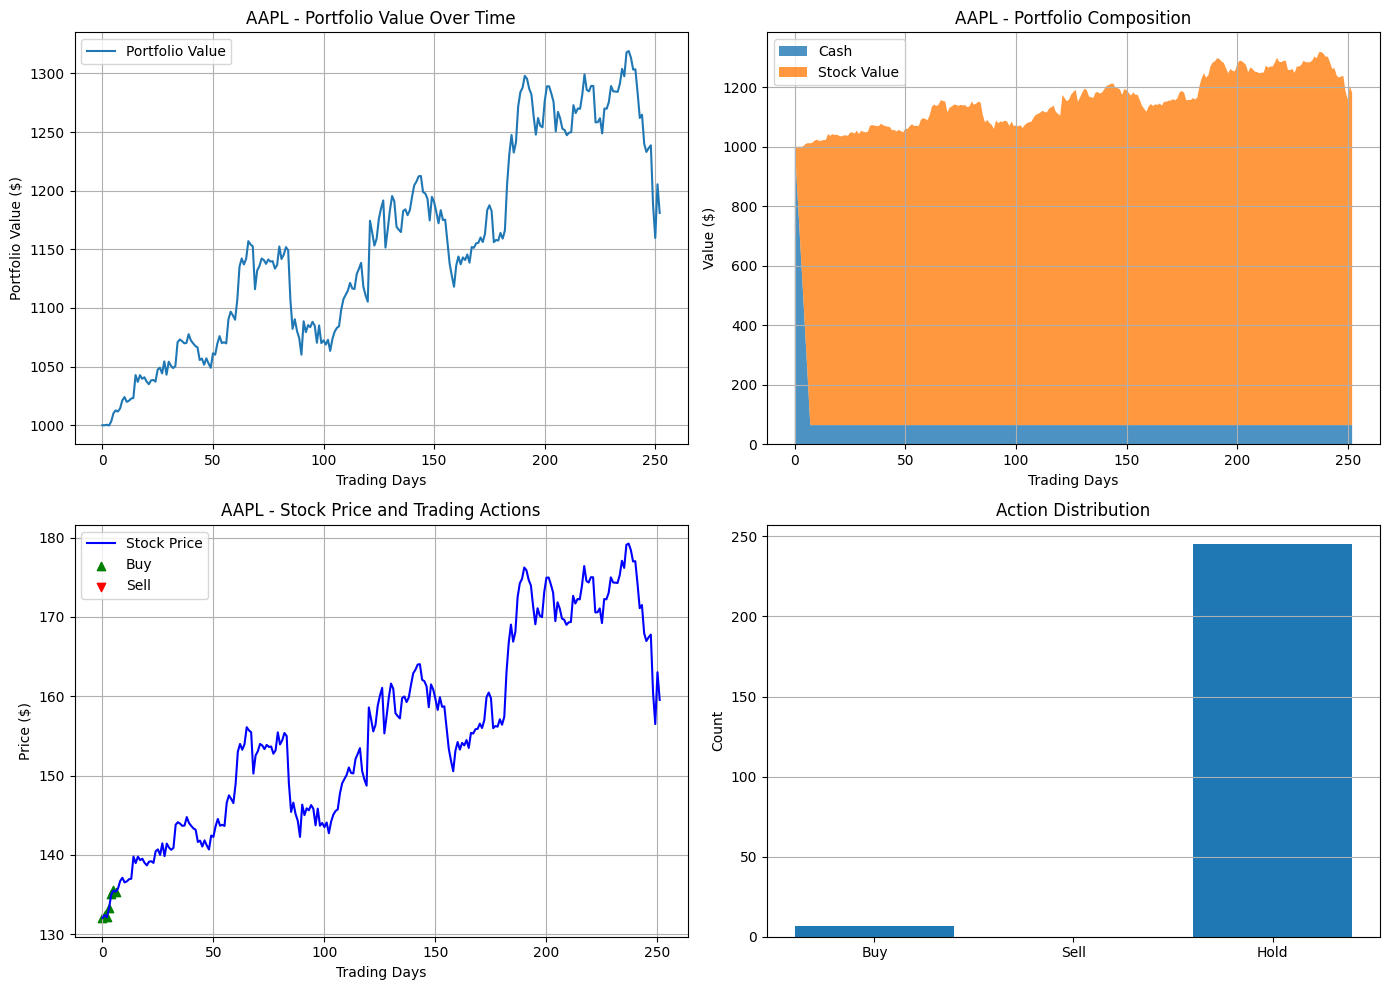

<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on MSFT stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1378.55
Total return: 37.85%
Buy & Hold return: 41.47%
Strategy outperformance: -3.62%
Maximum drawdown: 7.20%
Number of buys: 15
Number of sells: 0
Number of holds: 237


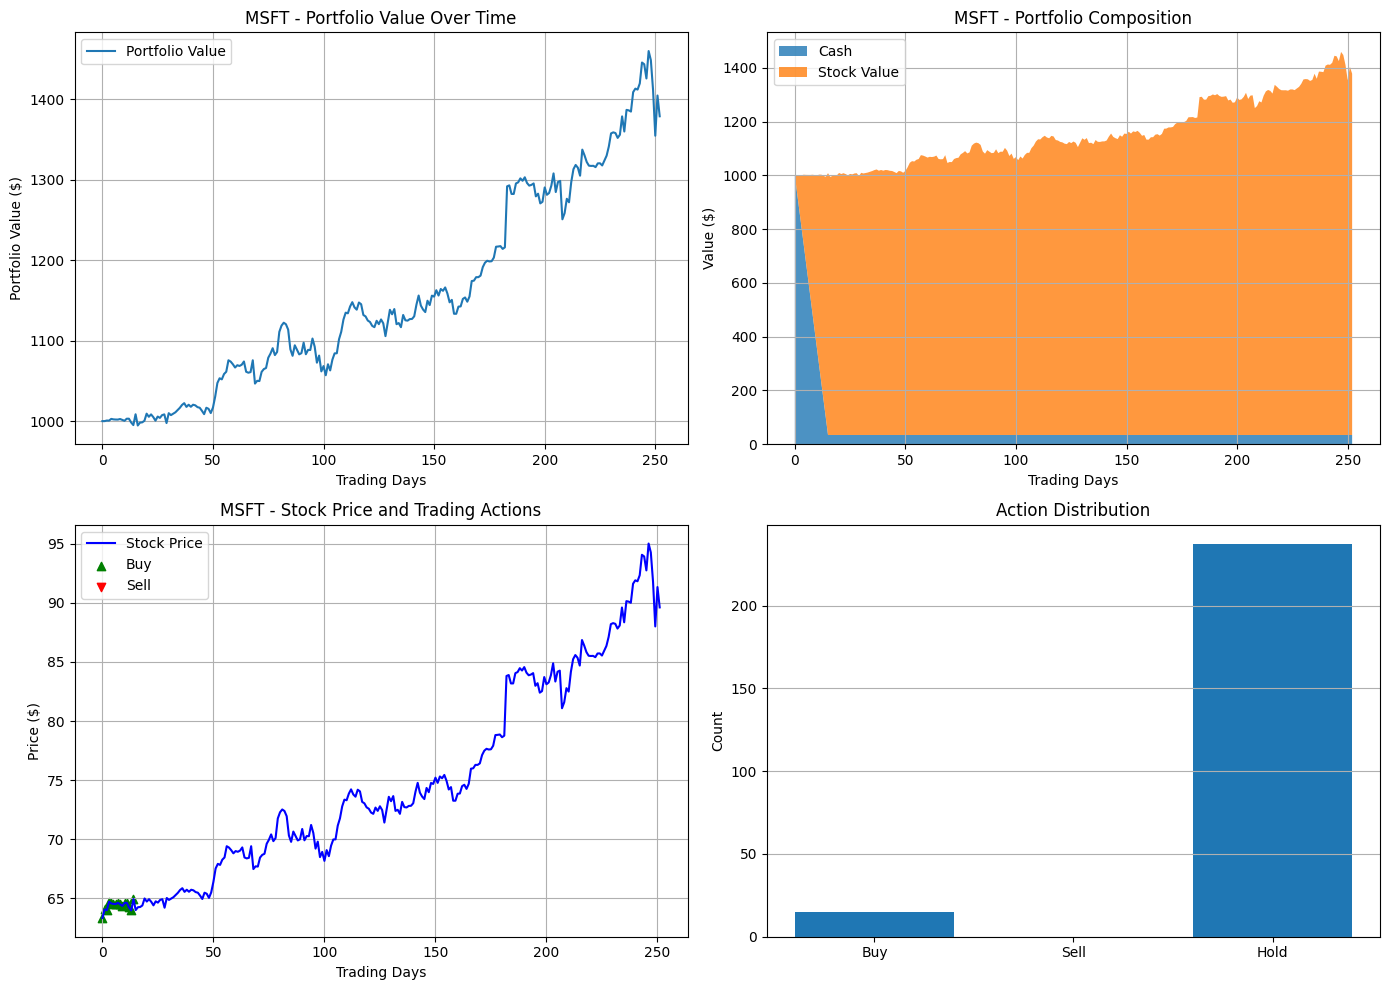

<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on AMZN stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1597.07
Total return: 59.71%
Buy & Hold return: 72.84%
Strategy outperformance: -13.13%
Maximum drawdown: 9.26%
Number of buys: 1
Number of sells: 0
Number of holds: 251


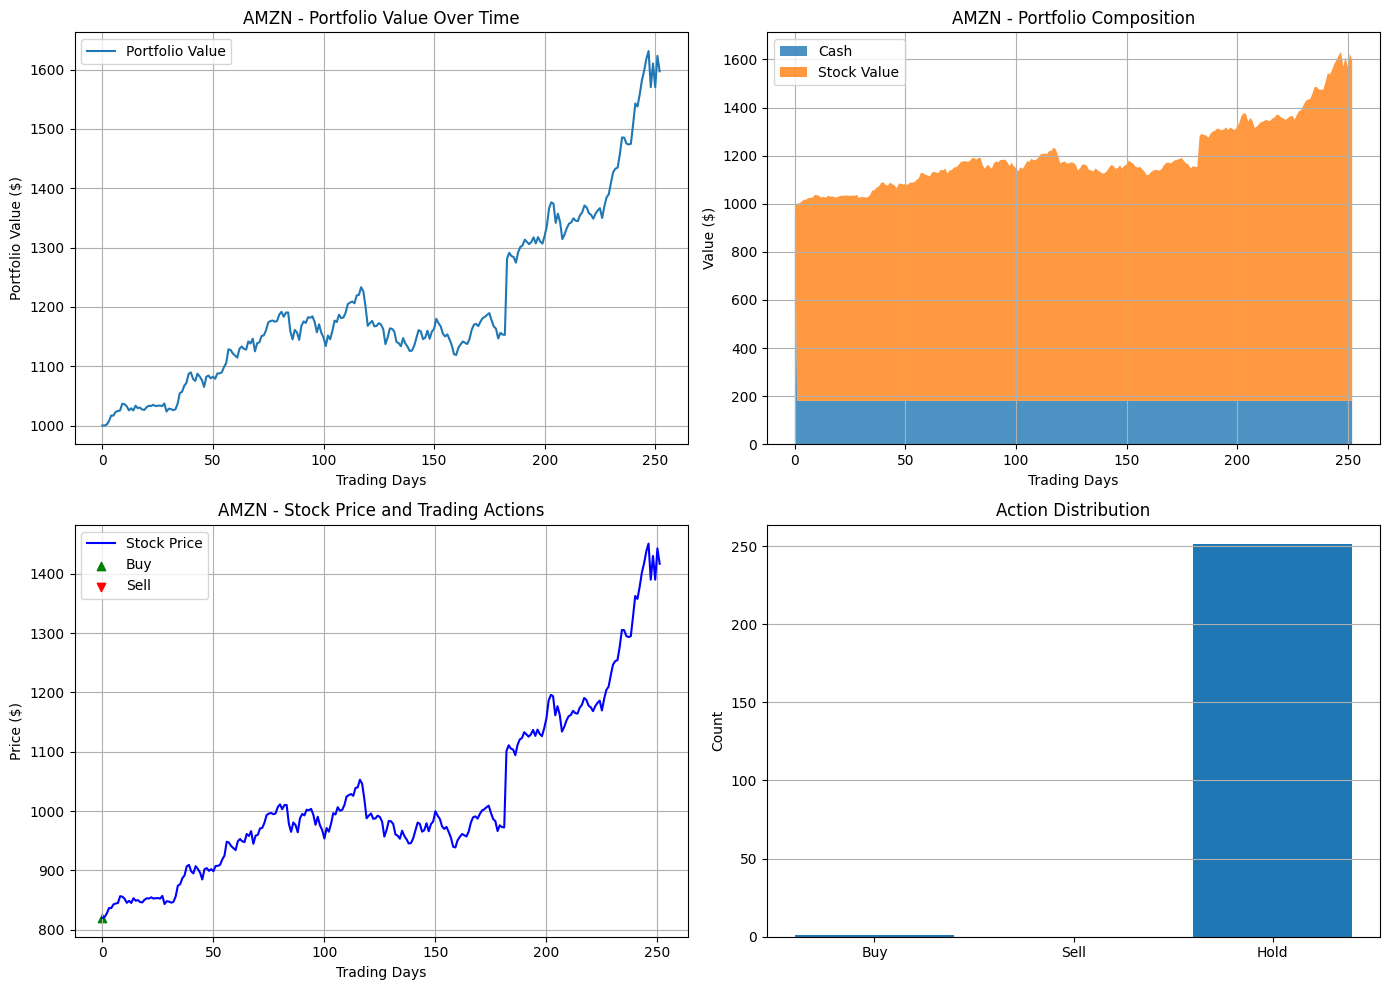

<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on FB stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1323.55
Total return: 32.35%
Buy & Hold return: 34.26%
Strategy outperformance: -1.91%
Maximum drawdown: 6.39%
Number of buys: 7
Number of sells: 0
Number of holds: 245


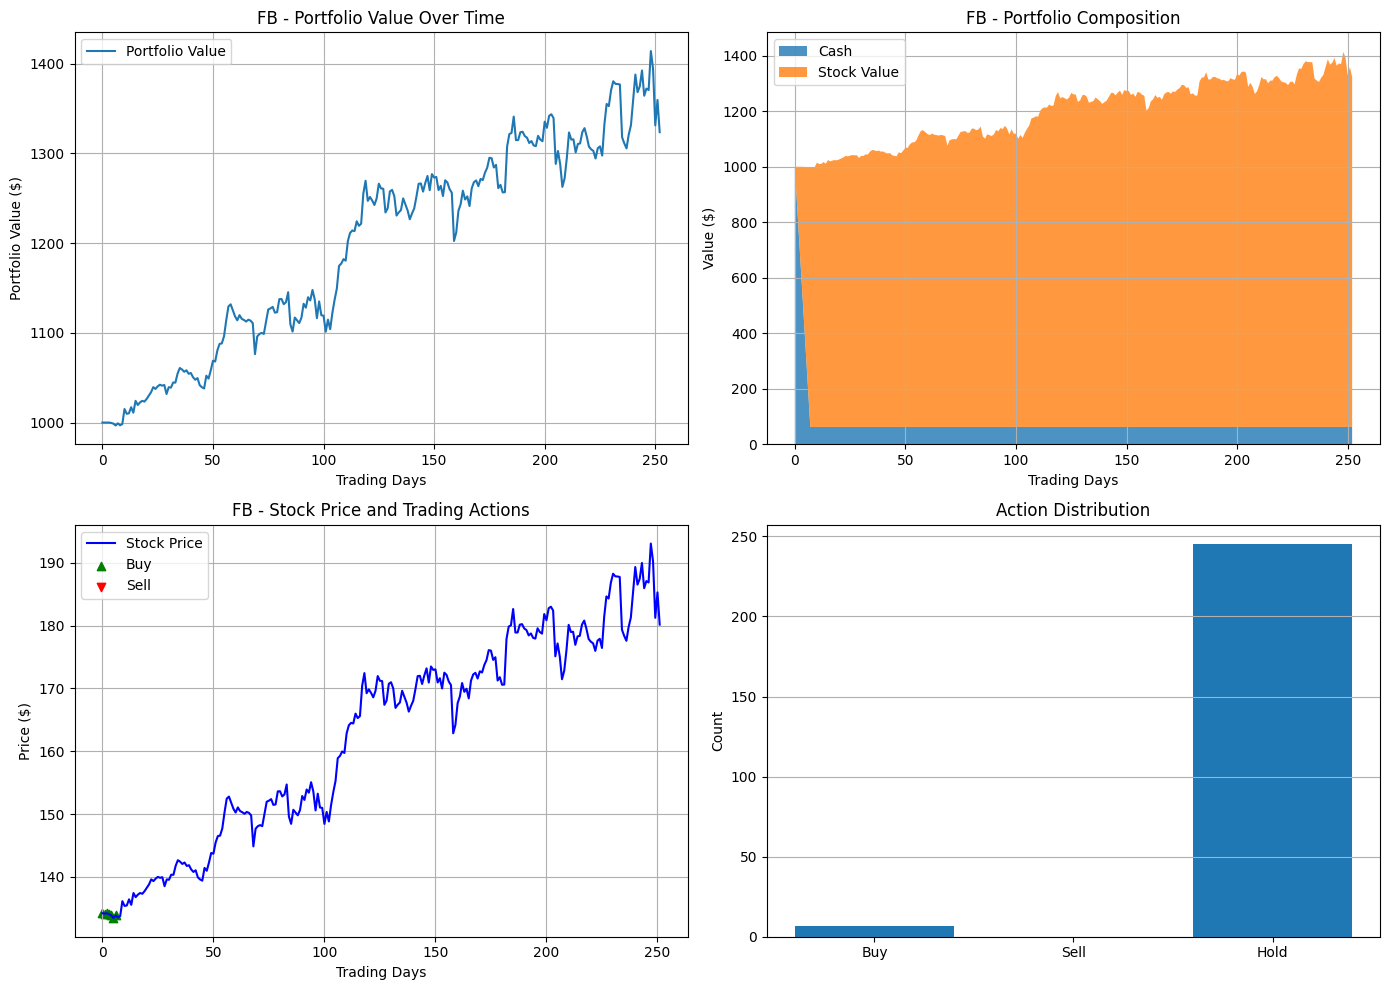

<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on ADBE stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1596.74
Total return: 59.67%
Buy & Hold return: 65.62%
Strategy outperformance: -5.95%
Maximum drawdown: 9.27%
Number of buys: 8
Number of sells: 0
Number of holds: 244


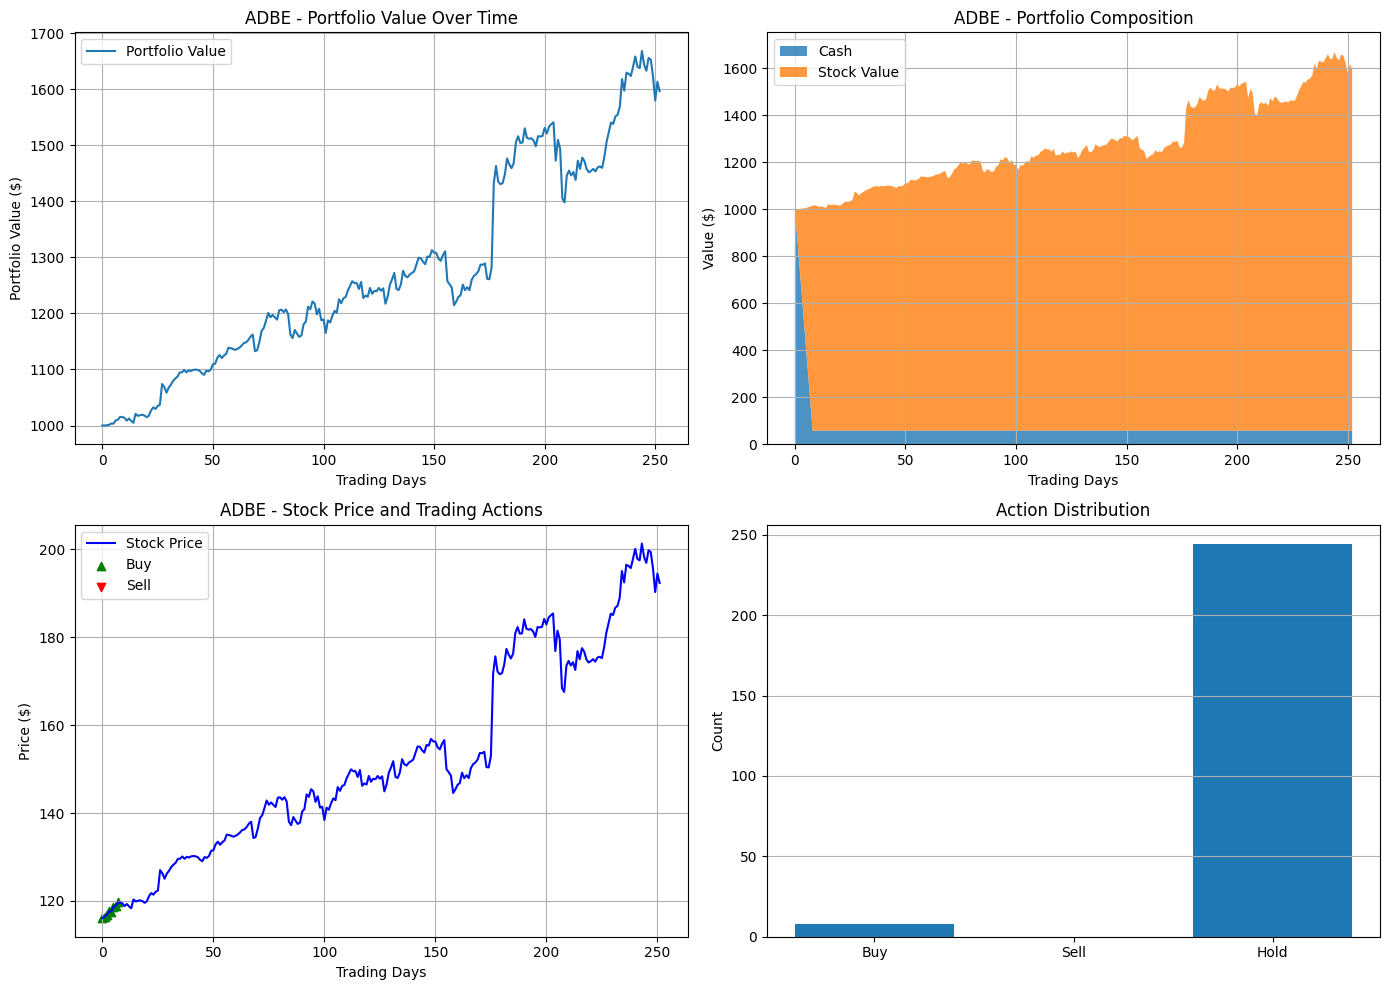

<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on GOOGL stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1225.53
Total return: 22.55%
Buy & Hold return: 27.18%
Strategy outperformance: -4.62%
Maximum drawdown: 9.73%
Number of buys: 1
Number of sells: 0
Number of holds: 251


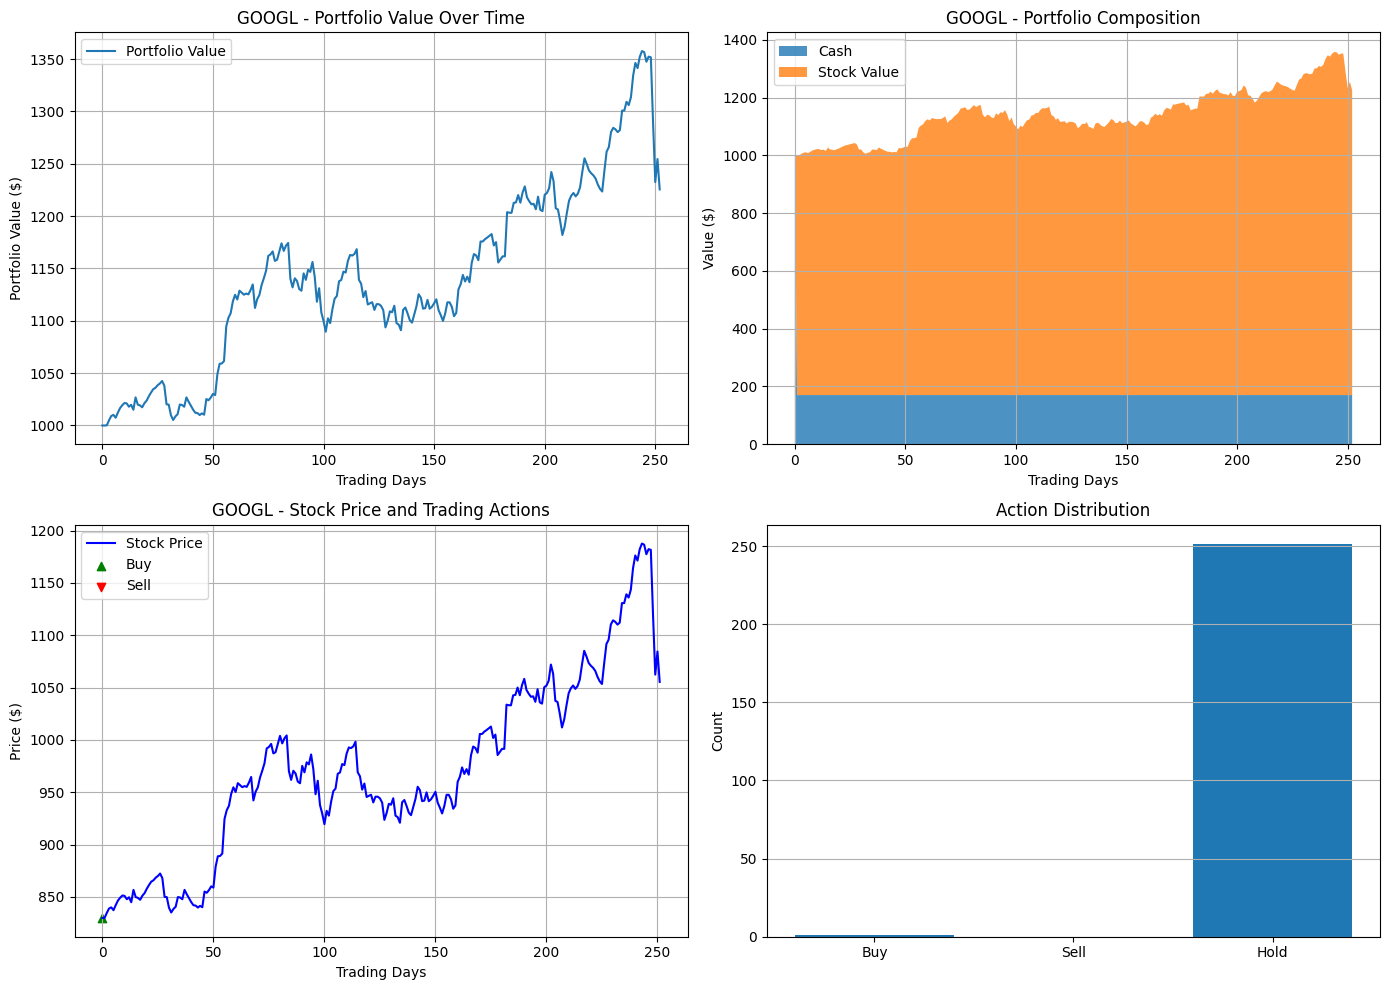

In [ ]:
# Load model
loaded_model = pk.load(open("dqn_model.pkl", 'rb'))

results_aapl, actions_aapl, metrics_aapl = test_any_stock('AAPL', loaded_model)

results_msft, actions_msft, metrics_msft = test_any_stock('MSFT', loaded_model)

results_msft, actions_msft, metrics_msft = test_any_stock('AMZN', loaded_model)

results_msft, actions_msft, metrics_msft = test_any_stock('FB', loaded_model)

results_msft, actions_msft, metrics_msft = test_any_stock('ADBE', loaded_model)

results_msft, actions_msft, metrics_msft = test_any_stock('GOOGL', loaded_model)

**Portfolio Value Over Time, Portfolio Composition, Stock Price with Trading Actions, Action Distribution**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def generate_research_visualizations(stock_symbol, net_worth, actions_taken, stocks_test, metrics):

    # daily returns
    daily_returns = [(net_worth[i] - net_worth[i-1])/net_worth[i-1] for i in range(1, len(net_worth))]

    plt.figure(figsize=(18, 20))

    # 1. Cumulative Return Comparison
    plt.subplot(3, 2, 1)
    initial_price = stocks_test.iloc[0]['close']
    buy_hold_values = [initial_price * net_worth[0] / initial_price]
    for i in range(1, len(stocks_test)):
        price = stocks_test.iloc[i]['close']
        buy_hold_values.append(price * net_worth[0] / initial_price)

    plt.plot(net_worth, label='DQL Strategy', color='blue')
    plt.plot(buy_hold_values, label='Buy & Hold', color='green', linestyle='--')
    plt.title(f'{stock_symbol} - Strategy vs. Buy & Hold')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)

    # 2. Return Distribution
    plt.subplot(3, 2, 2)
    sns.histplot(daily_returns, kde=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')

    mean_return = np.mean(daily_returns)
    std_return = np.std(daily_returns)
    skew = stats.skew(daily_returns)
    kurtosis = stats.kurtosis(daily_returns)

    stats_text = f"Mean: {mean_return:.4f}\nStd Dev: {std_return:.4f}\n"
    stats_text += f"Skewness: {skew:.4f}\nKurtosis: {kurtosis:.4f}"
    plt.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # 3. Drawdown Analysis
    plt.subplot(3, 2, 3)
    peak = net_worth[0]
    drawdowns = []
    for value in net_worth:
        if value > peak:
            peak = value
            drawdowns.append(0)
        else:
            drawdown = (peak - value) / peak * 100
            drawdowns.append(drawdown)

    plt.plot(drawdowns, color='red')
    plt.title('Portfolio Drawdown Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)

    # 4. Action Effect Analysis
    plt.subplot(3, 2, 4)
    buy_followed_returns = []
    sell_followed_returns = []
    hold_followed_returns = []

    for i in range(len(actions_taken)-1):
        if actions_taken[i] == 0:  # Buy
            buy_followed_returns.append(daily_returns[i+1])
        elif actions_taken[i] == 1:  # Sell
            sell_followed_returns.append(daily_returns[i+1])
        elif actions_taken[i] == 2:  # Hold
            hold_followed_returns.append(daily_returns[i+1])

    # Box plot of returns by action
    action_returns = [buy_followed_returns, sell_followed_returns, hold_followed_returns]
    plt.boxplot(action_returns, labels=['Buy', 'Sell', 'Hold'])
    plt.title('Next-Day Returns Following Each Action')
    plt.ylabel('Return')
    plt.grid(True, axis='y')

    # We add means to the plot
    means = [np.mean(ret) if len(ret) > 0 else 0 for ret in action_returns]
    for i, mean in enumerate(means):
        plt.annotate(f'Mean: {mean:.4f}', xy=(i+1, mean),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', va='bottom')

    # 5. Rolling Performance
    plt.subplot(3, 2, 5)
    # (20-day window)
    rolling_returns = []
    window_size = 20
    for i in range(window_size, len(net_worth)):
        window_return = (net_worth[i] - net_worth[i-window_size]) / net_worth[i-window_size] * 100
        rolling_returns.append(window_return)

    plt.plot(rolling_returns, color='purple')
    plt.title(f'{window_size}-Day Rolling Returns')
    plt.xlabel('Trading Day')
    plt.ylabel('Rolling Return (%)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True)

    # 6. Action Transitions
    plt.subplot(3, 2, 6)
    action_names = ['Buy', 'Sell', 'Hold']

    # transition matrix
    transition_matrix = np.zeros((3, 3))
    for i in range(len(actions_taken)-1):
        current_action = actions_taken[i]
        next_action = actions_taken[i+1]
        transition_matrix[current_action][next_action] += 1

    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(transition_matrix, row_sums, where=row_sums!=0)

    sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='viridis',
                xticklabels=action_names, yticklabels=action_names)
    plt.title('Action Transition Probabilities')
    plt.xlabel('Next Action')
    plt.ylabel('Current Action')

    plt.tight_layout()
    plt.savefig(f'{stock_symbol}_advanced_analysis.png', dpi=300)
    plt.show()

    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)

    # winning and losing days
    winning_days = sum(1 for r in daily_returns if r > 0)
    losing_days = sum(1 for r in daily_returns if r < 0)
    win_rate = winning_days / len(daily_returns) if daily_returns else 0

    # max consecutive wins/losses
    consecutive_wins = 0
    consecutive_losses = 0
    current_win_streak = 0
    current_loss_streak = 0

    for r in daily_returns:
        if r > 0:
            current_win_streak += 1
            current_loss_streak = 0
        elif r < 0:
            current_loss_streak += 1
            current_win_streak = 0

        consecutive_wins = max(consecutive_wins, current_win_streak)
        consecutive_losses = max(consecutive_losses, current_loss_streak)

    additional_metrics = {
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate * 100,
        'winning_days': winning_days,
        'losing_days': losing_days,
        'consecutive_wins_max': consecutive_wins,
        'consecutive_losses_max': consecutive_losses,
        'mean_daily_return': np.mean(daily_returns) * 100,
        'volatility_daily': np.std(daily_returns) * 100,
        'volatility_annualized': np.std(daily_returns) * np.sqrt(252) * 100
    }

    combined_metrics = {**metrics, **additional_metrics}

    print("\n===== Additional Performance Metrics =====")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Win Rate: {win_rate*100:.2f}%")
    print(f"Winning/Losing Days: {winning_days}/{losing_days}")
    print(f"Max Consecutive Wins: {consecutive_wins}")
    print(f"Max Consecutive Losses: {consecutive_losses}")
    print(f"Mean Daily Return: {np.mean(daily_returns)*100:.4f}%")
    print(f"Daily Volatility: {np.std(daily_returns)*100:.4f}%")
    print(f"Annualized Volatility: {np.std(daily_returns)*np.sqrt(252)*100:.4f}%")

    return combined_metrics



<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on AAPL stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1181.04
Total return: 18.10%
Buy & Hold return: 20.83%
Strategy outperformance: -2.72%
Maximum drawdown: 12.08%
Number of buys: 7
Number of sells: 0
Number of holds: 245


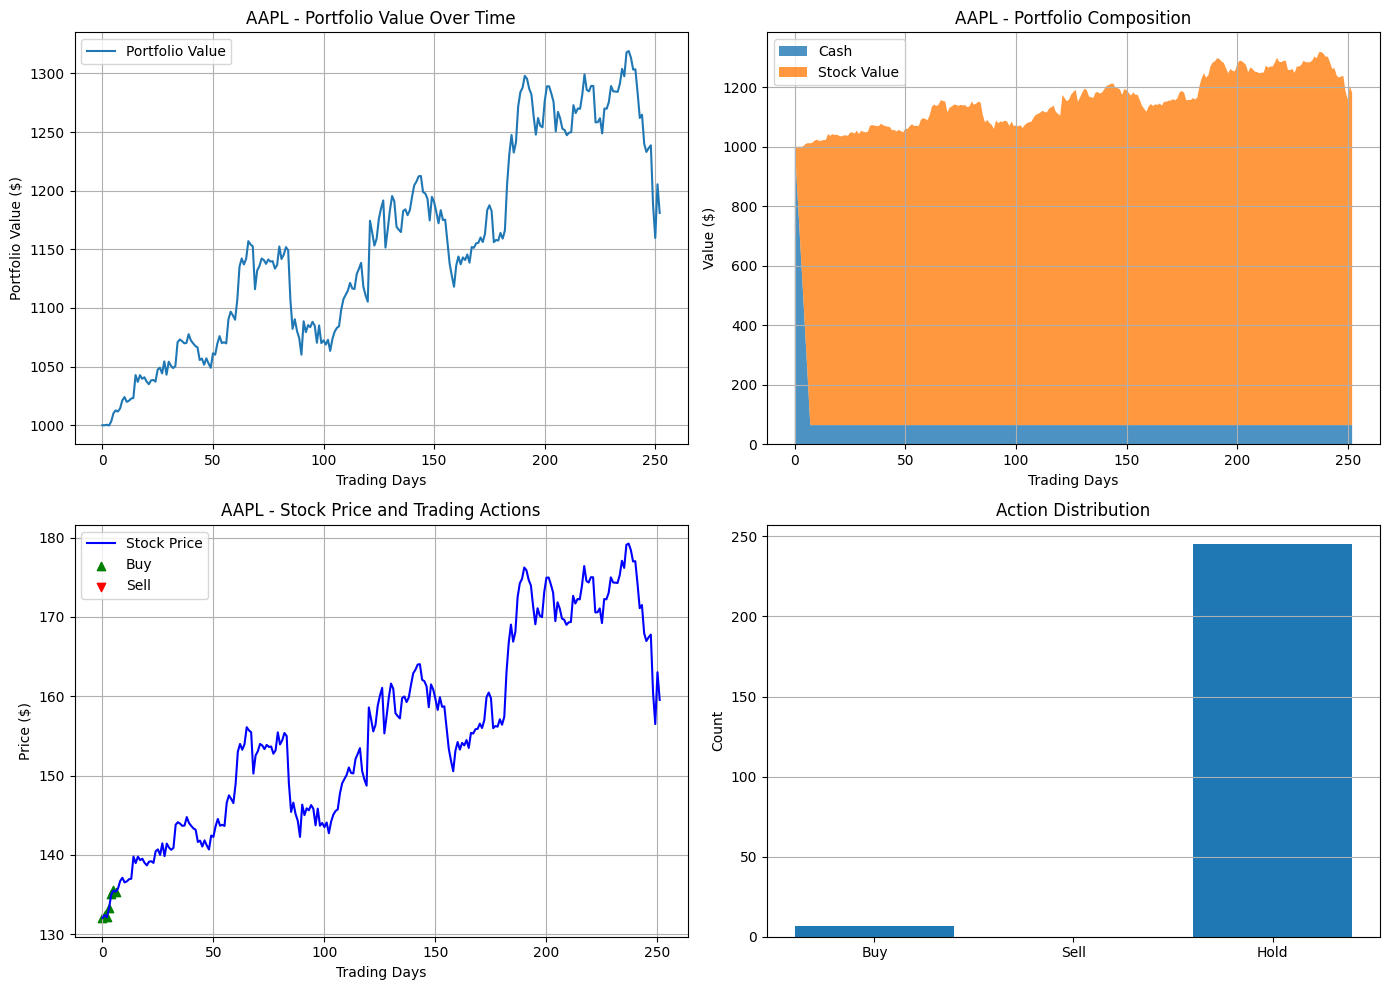

In [ ]:
single_stock_symbol = 'AAPL'
net_worth, actions_taken, metrics = test_any_stock(single_stock_symbol, loaded_model)

<ipython-input-54-614fab805421>:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(action_returns, labels=['Buy', 'Sell', 'Hold'])


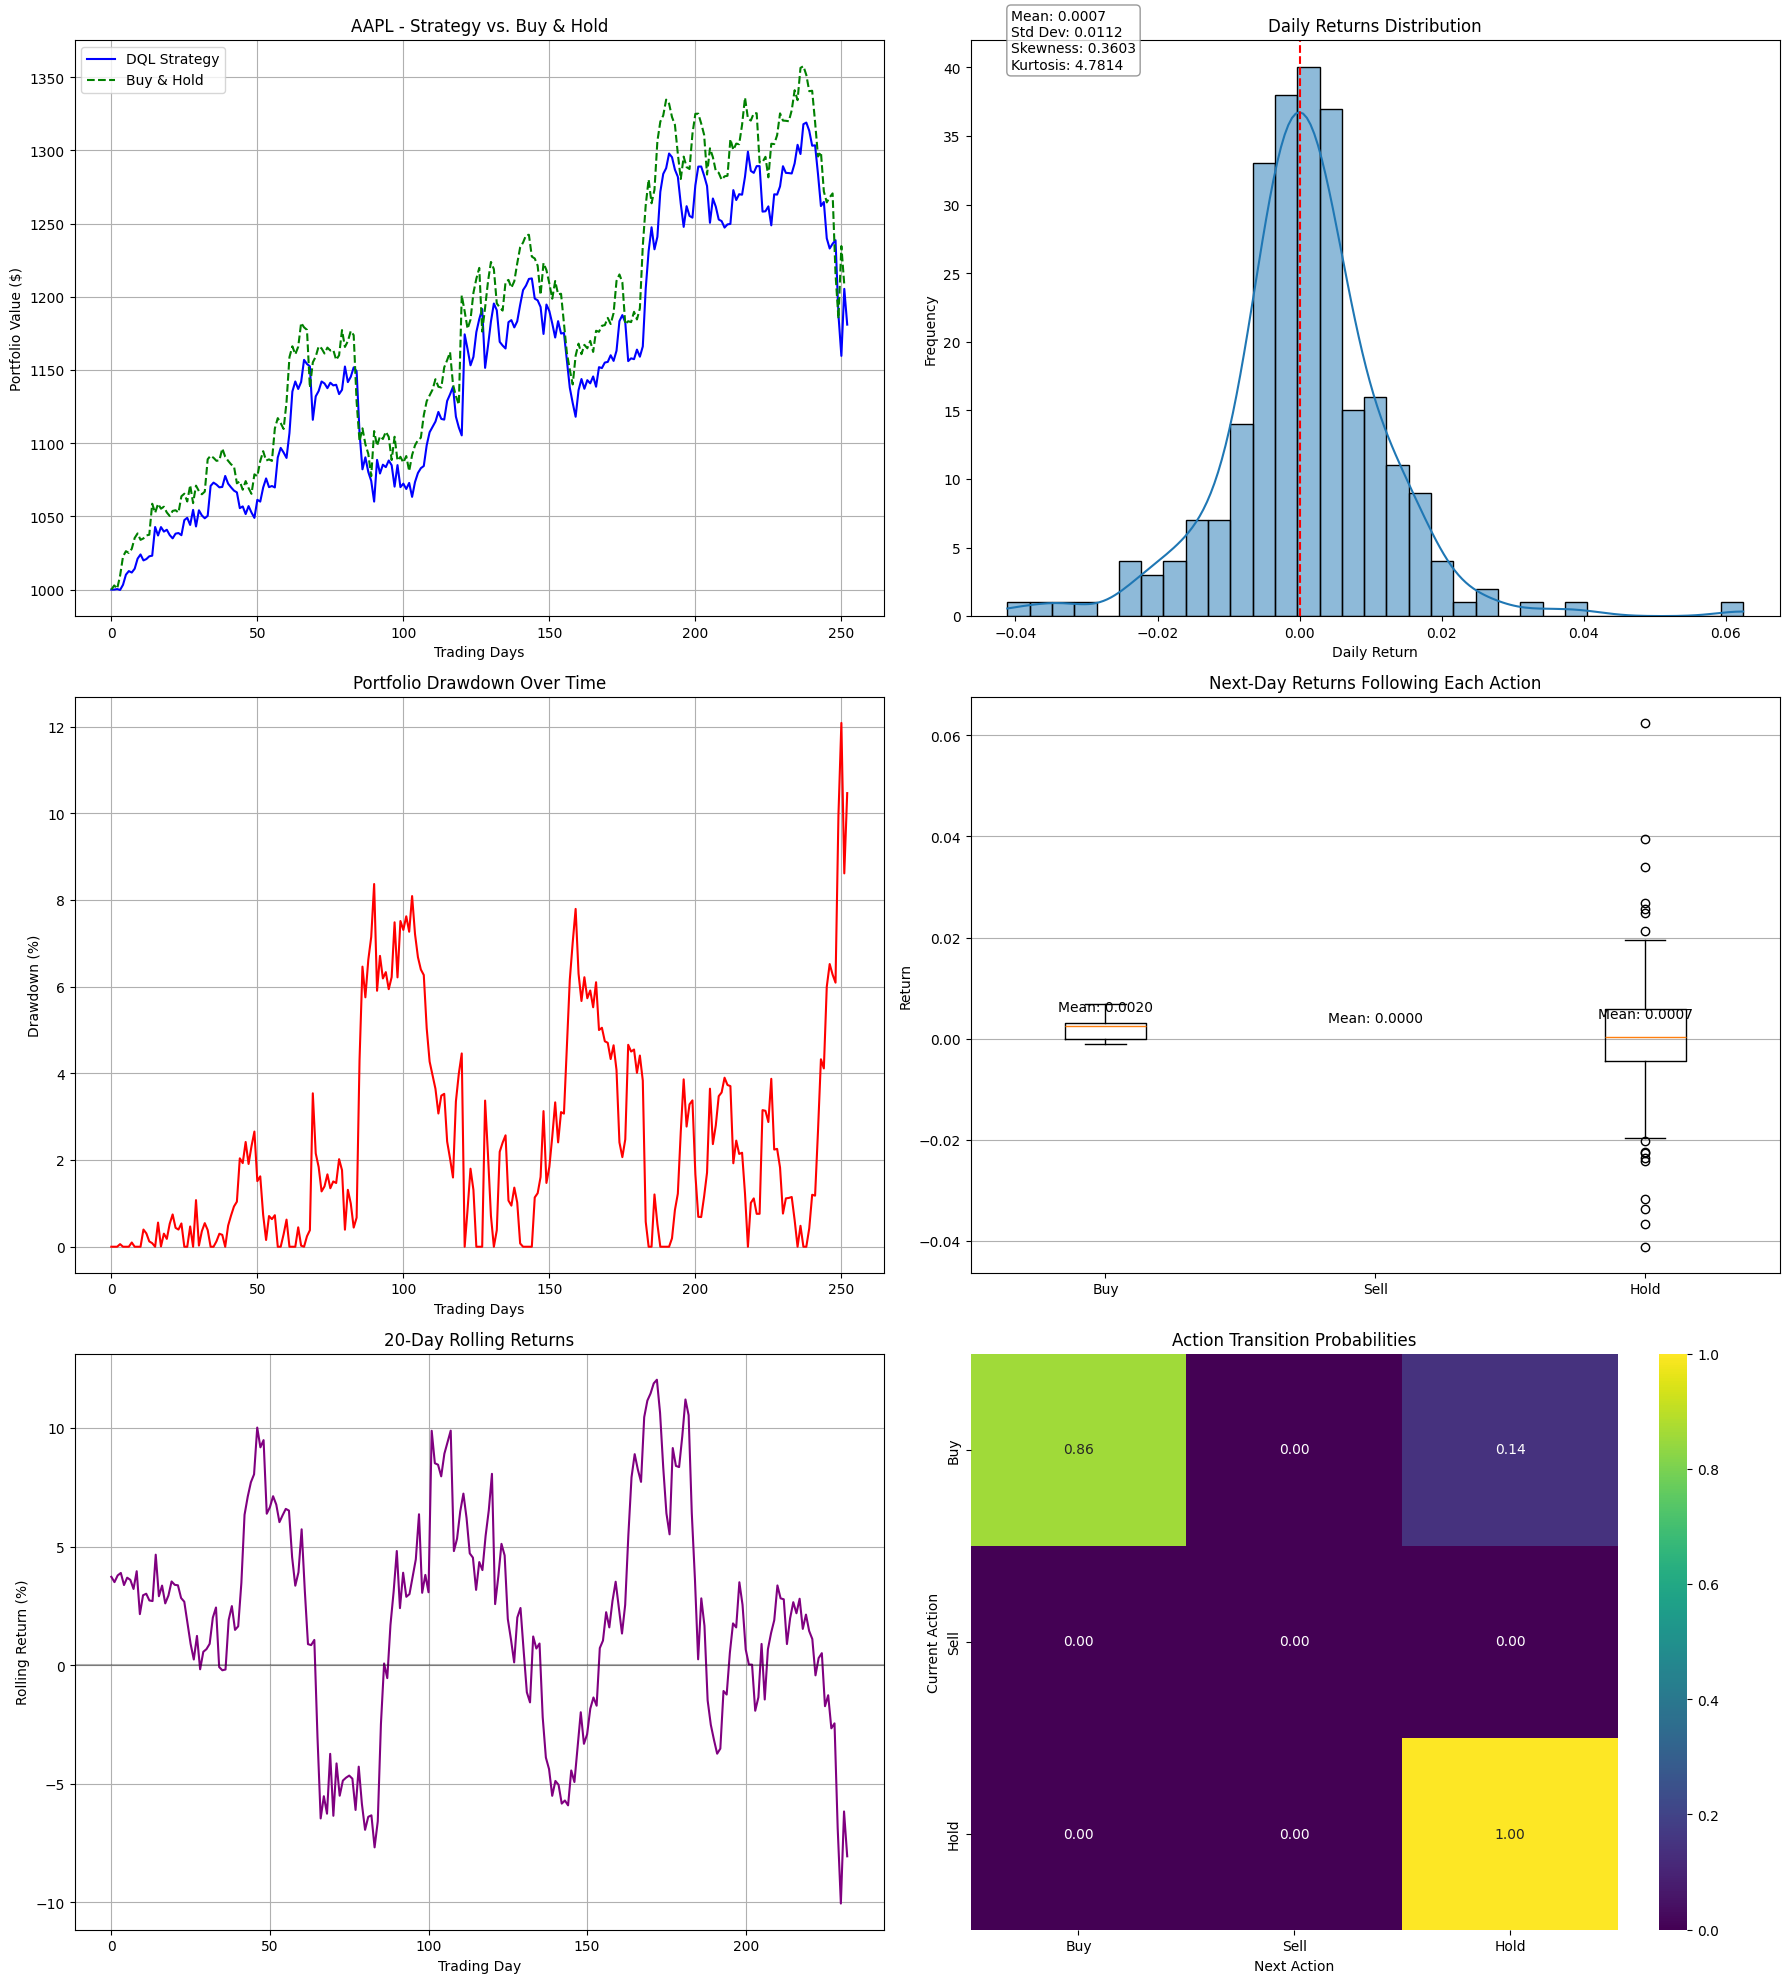


===== Additional Performance Metrics =====
Sharpe Ratio: 1.0222
Win Rate: 52.38%
Winning/Losing Days: 132/118
Max Consecutive Wins: 9
Max Consecutive Losses: 5
Mean Daily Return: 0.0723%
Daily Volatility: 1.1234%
Annualized Volatility: 17.8339%


In [ ]:
enhanced_metrics = generate_research_visualizations(single_stock_symbol, net_worth, actions_taken, stocks_test, metrics)

**Cross-Stock Performance Analysis**

In [ ]:
def analyze_multiple_stocks(stock_symbols, trained_model, data_path='all_stocks_5yr.csv'):

    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    results = []

    for symbol in stock_symbols:
        print(f"\nTesting model on {symbol}...")
        net_worth, actions, metrics = test_any_stock(symbol, trained_model, data_path)

        if metrics:
            metrics['stock_symbol'] = symbol
            results.append(metrics)

    if not results:
        print("No successful test results to analyze.")
        return None

    results_df = pd.DataFrame(results)

    print("\n===== Cross-Stock Performance Summary =====")
    print(f"Number of stocks tested: {len(results_df)}")
    print(f"Average return: {results_df['total_return_pct'].mean():.2f}%")
    print(f"Average outperformance vs buy & hold: {results_df['outperformance'].mean():.2f}%")
    print(f"Percentage of stocks outperformed: {(results_df['outperformance'] > 0).mean() * 100:.1f}%")

    plt.figure(figsize=(18, 12))

    # 1. Returns comparison by stock
    plt.subplot(2, 2, 1)
    comparison_df = results_df[['stock_symbol', 'total_return_pct', 'buy_hold_return_pct']]
    comparison_df = pd.melt(comparison_df, id_vars=['stock_symbol'],
                            value_vars=['total_return_pct', 'buy_hold_return_pct'],
                            var_name='Strategy', value_name='Return (%)')
    comparison_df['Strategy'] = comparison_df['Strategy'].map({
        'total_return_pct': 'DQL Strategy',
        'buy_hold_return_pct': 'Buy & Hold'
    })

    sns.barplot(x='stock_symbol', y='Return (%)', hue='Strategy', data=comparison_df)
    plt.title('Strategy Returns by Stock')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 2. Outperformance by stock
    plt.subplot(2, 2, 2)
    outperf_df = results_df[['stock_symbol', 'outperformance']].sort_values('outperformance')
    sns.barplot(x='stock_symbol', y='outperformance', data=outperf_df,
                palette=['red' if x < 0 else 'green' for x in outperf_df['outperformance']])
    plt.title('Strategy Outperformance vs Buy & Hold')
    plt.ylabel('Outperformance (%)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # 3. Return vs Maximum Drawdown scatter plot
    plt.subplot(2, 2, 3)
    sns.scatterplot(x='max_drawdown_pct', y='total_return_pct', data=results_df, s=100)

    for i, row in results_df.iterrows():
        plt.annotate(row['stock_symbol'],
                     (row['max_drawdown_pct'], row['total_return_pct']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Risk-Return Profile')
    plt.xlabel('Maximum Drawdown (%)')
    plt.ylabel('Total Return (%)')
    plt.grid(True)

    # 4. Trading activity comparison
    plt.subplot(2, 2, 4)
    activity_df = results_df[['stock_symbol', 'num_buys', 'num_sells', 'num_holds']]
    activity_df = pd.melt(activity_df, id_vars=['stock_symbol'],
                         value_vars=['num_buys', 'num_sells', 'num_holds'],
                         var_name='Action', value_name='Count')
    activity_df['Action'] = activity_df['Action'].map({
        'num_buys': 'Buy',
        'num_sells': 'Sell',
        'num_holds': 'Hold'
    })

    sns.barplot(x='stock_symbol', y='Count', hue='Action', data=activity_df)
    plt.title('Trading Activity by Stock')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('cross_stock_performance.png', dpi=300)
    plt.show()

    return results_df



Testing model on AAPL...


<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on AAPL stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1181.04
Total return: 18.10%
Buy & Hold return: 20.83%
Strategy outperformance: -2.72%
Maximum drawdown: 12.08%
Number of buys: 7
Number of sells: 0
Number of holds: 245


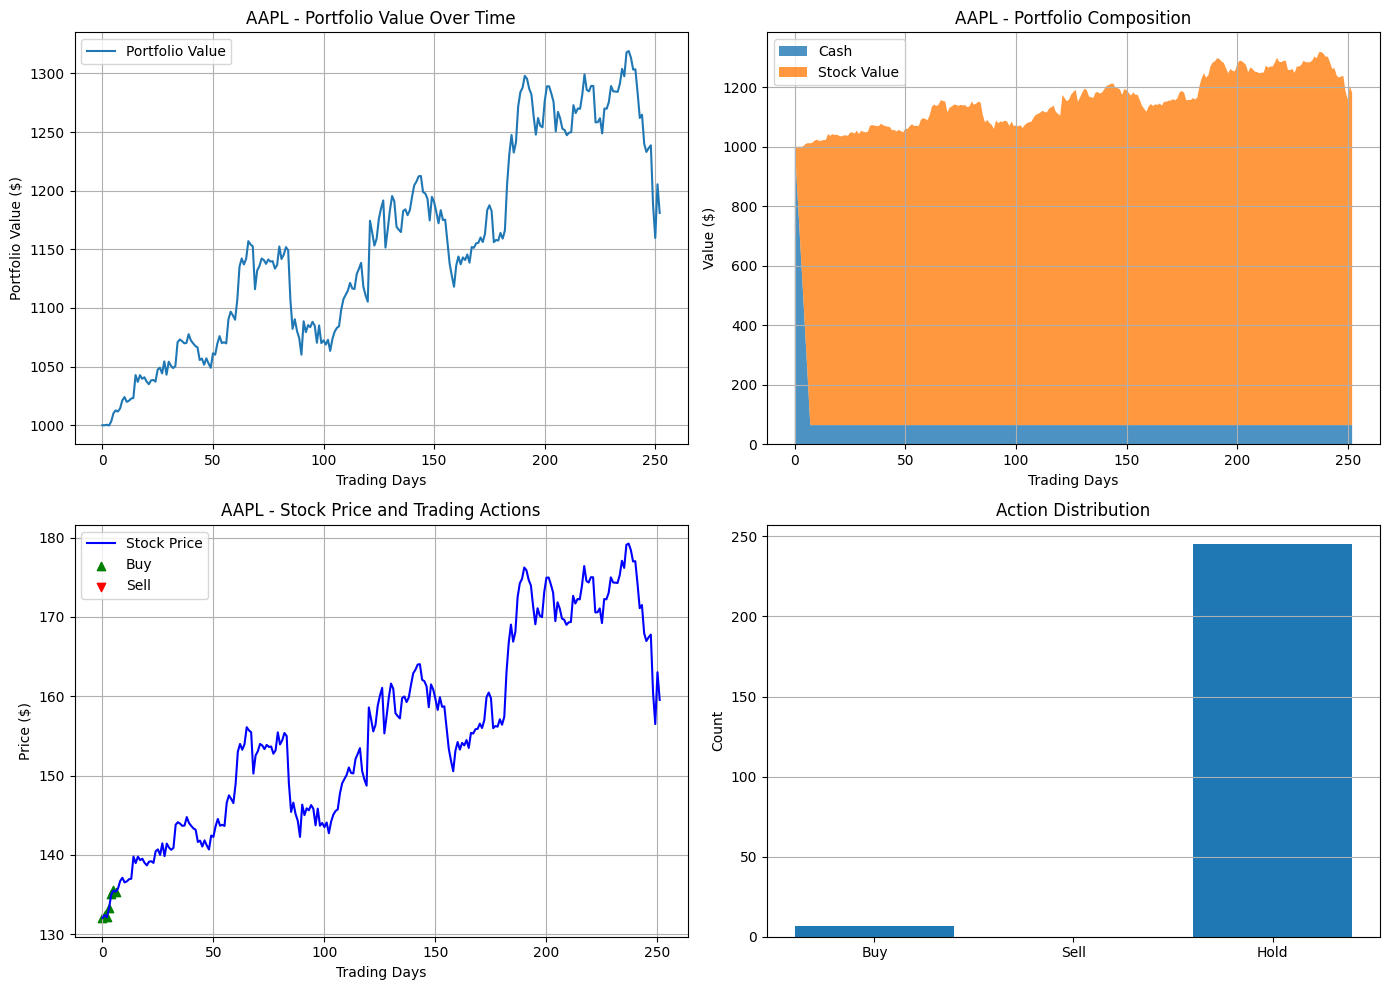


Testing model on MSFT...


<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on MSFT stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1378.55
Total return: 37.85%
Buy & Hold return: 41.47%
Strategy outperformance: -3.62%
Maximum drawdown: 7.20%
Number of buys: 15
Number of sells: 0
Number of holds: 237


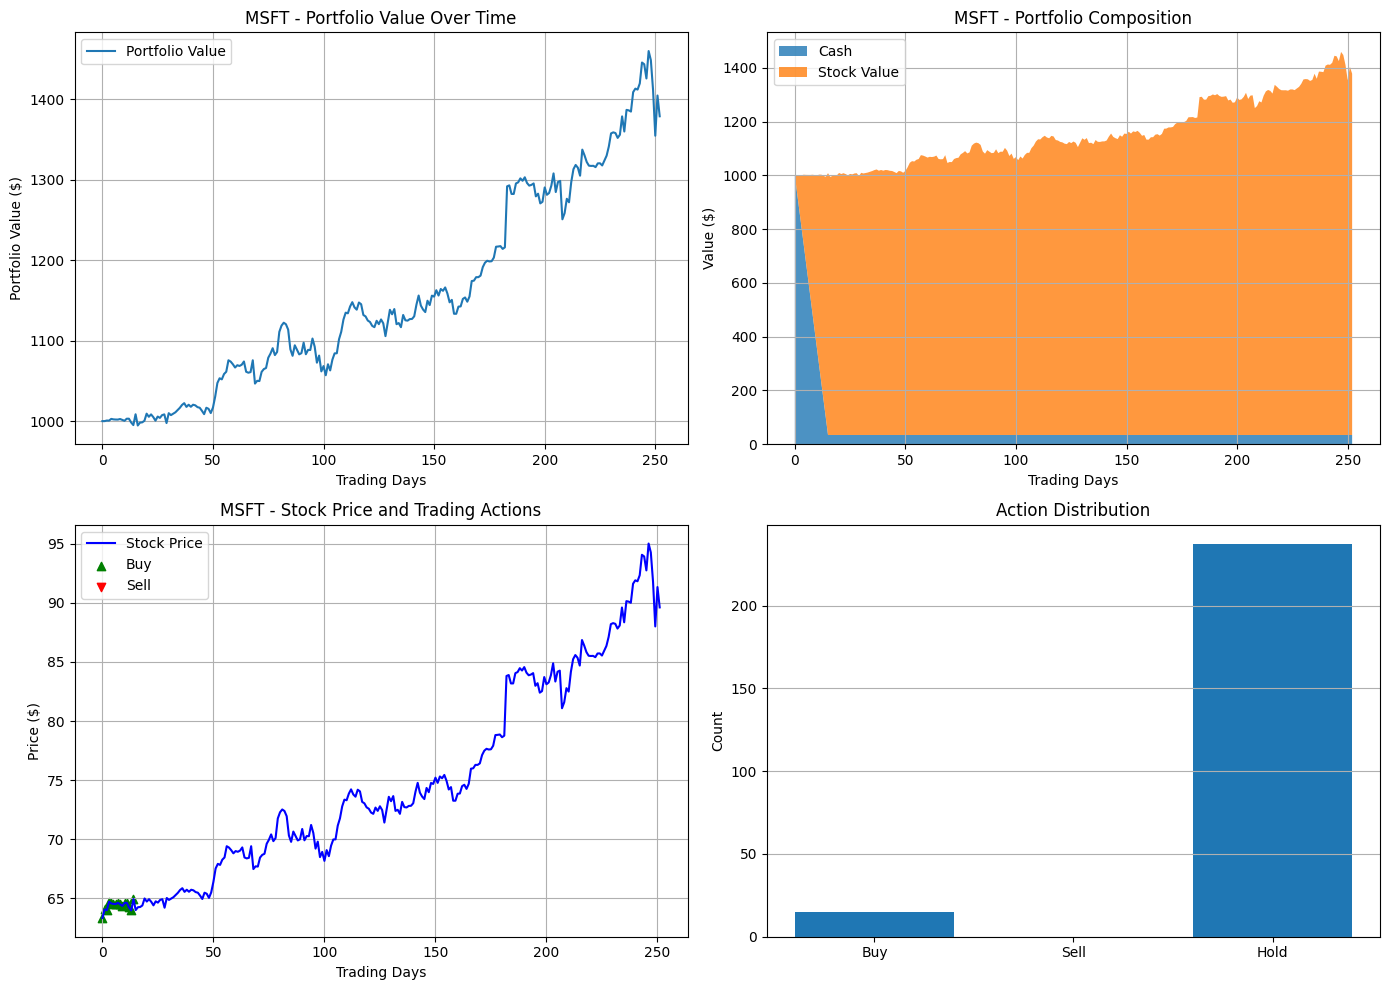


Testing model on GOOGL...


<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on GOOGL stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1225.53
Total return: 22.55%
Buy & Hold return: 27.18%
Strategy outperformance: -4.62%
Maximum drawdown: 9.73%
Number of buys: 1
Number of sells: 0
Number of holds: 251


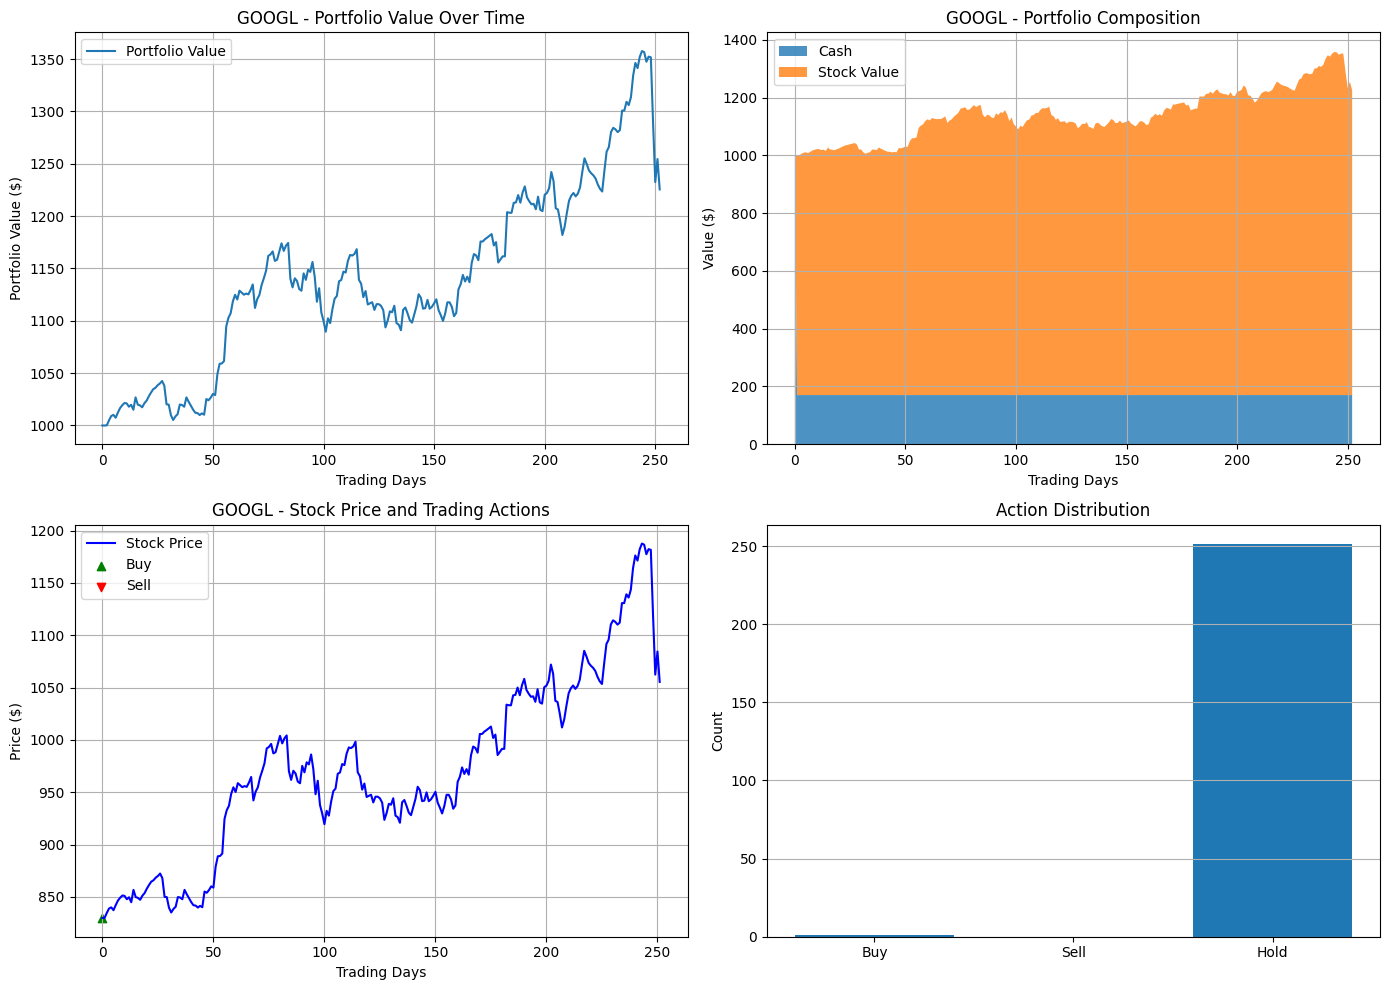


Testing model on AMZN...


<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on AMZN stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1597.07
Total return: 59.71%
Buy & Hold return: 72.84%
Strategy outperformance: -13.13%
Maximum drawdown: 9.26%
Number of buys: 1
Number of sells: 0
Number of holds: 251


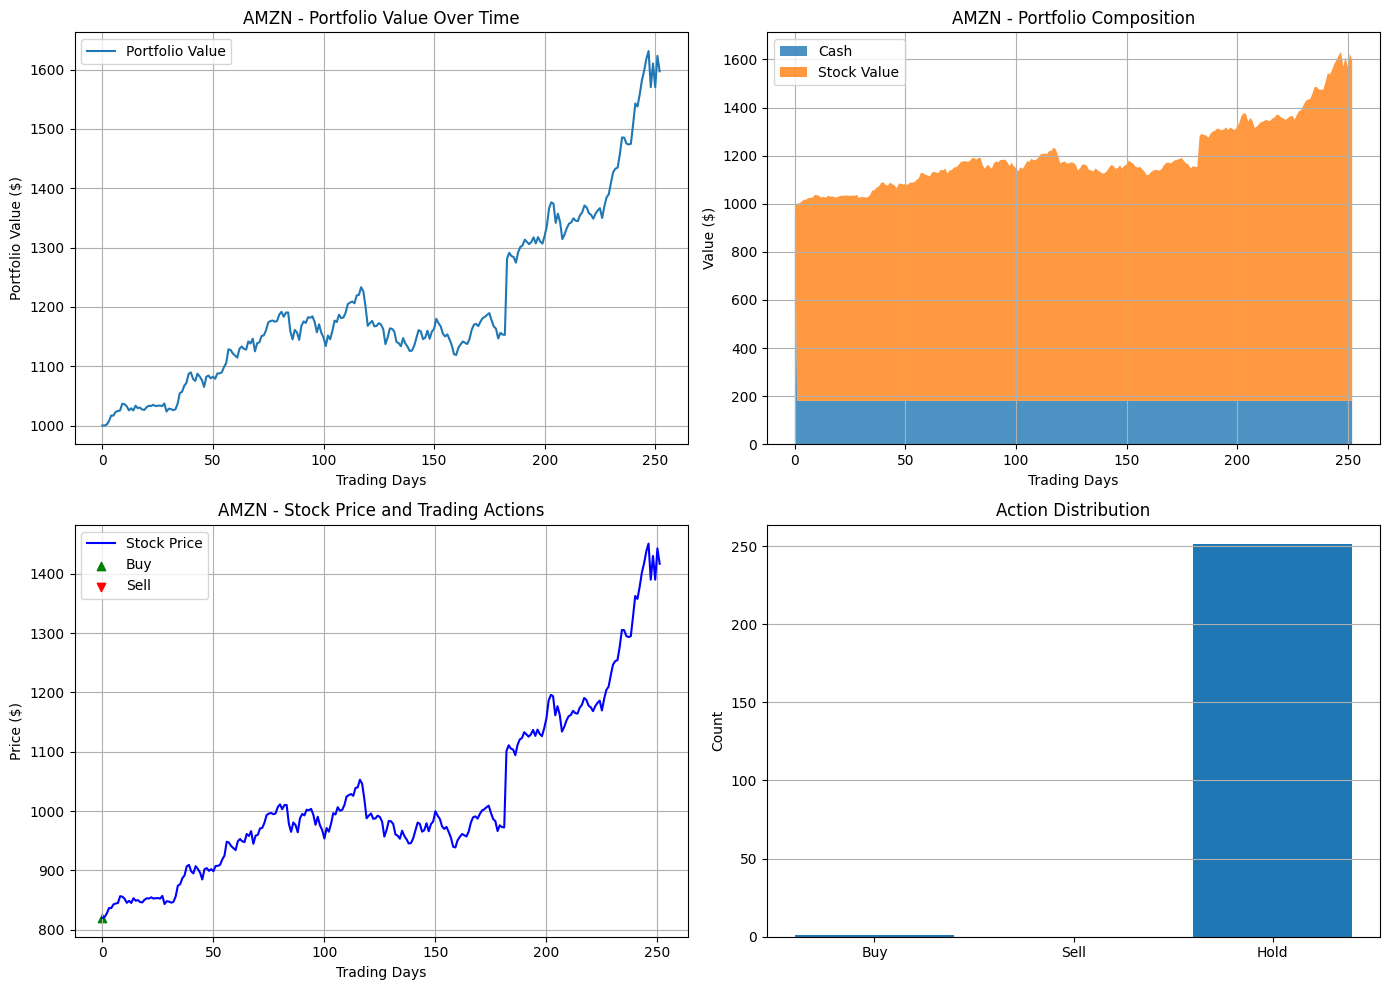


Testing model on FB...


<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on FB stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1323.55
Total return: 32.35%
Buy & Hold return: 34.26%
Strategy outperformance: -1.91%
Maximum drawdown: 6.39%
Number of buys: 7
Number of sells: 0
Number of holds: 245


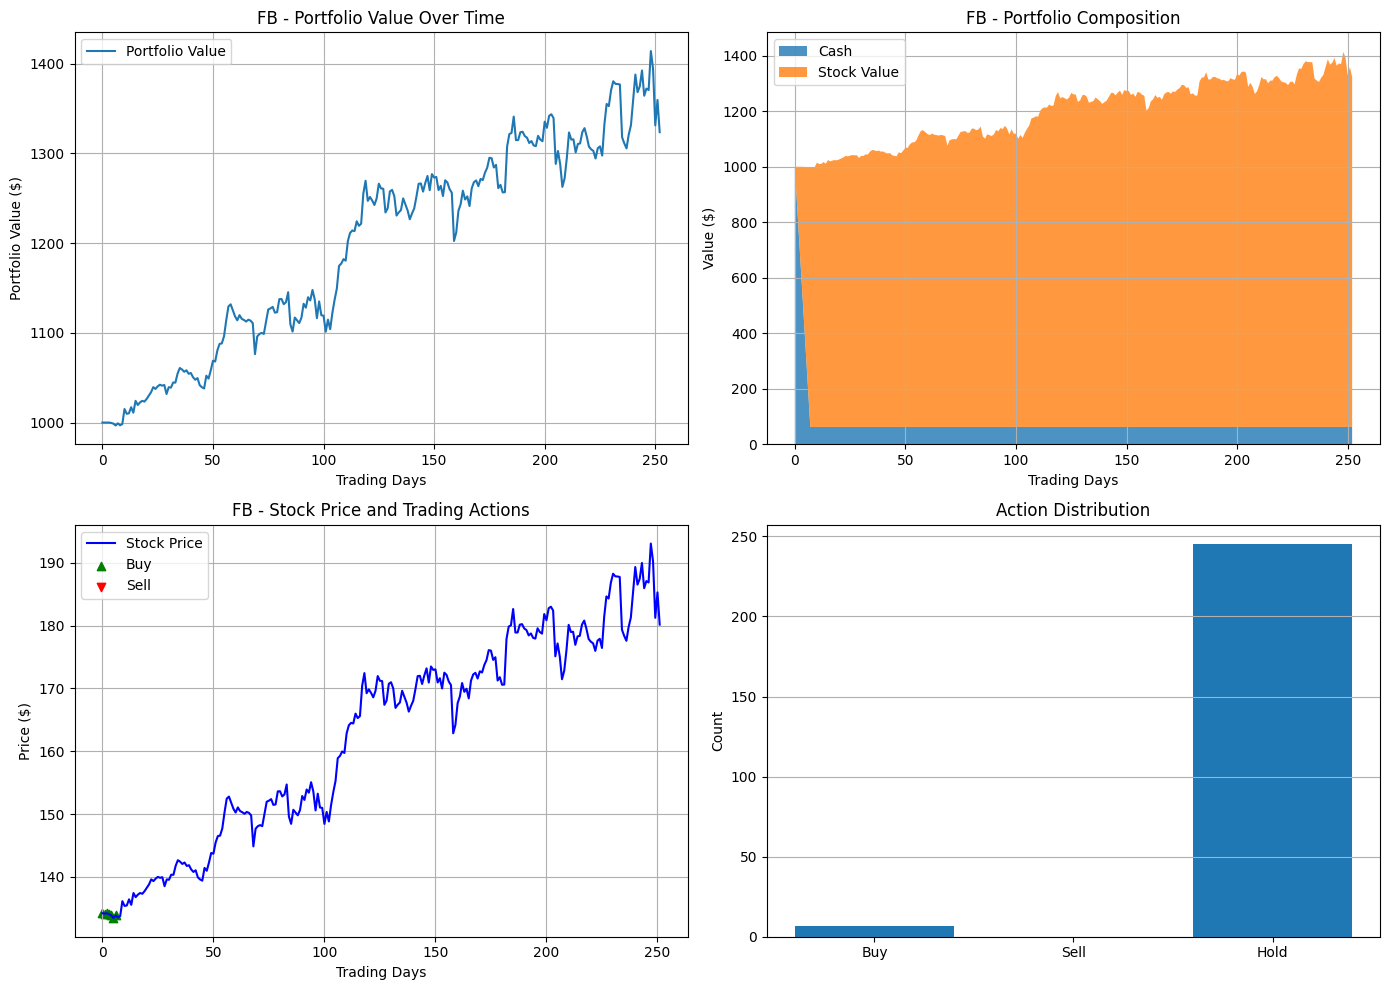


Testing model on NFLX...


<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on NFLX stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1852.40
Total return: 85.24%
Buy & Hold return: 82.78%
Strategy outperformance: 2.46%
Maximum drawdown: 12.23%
Number of buys: 7
Number of sells: 0
Number of holds: 245


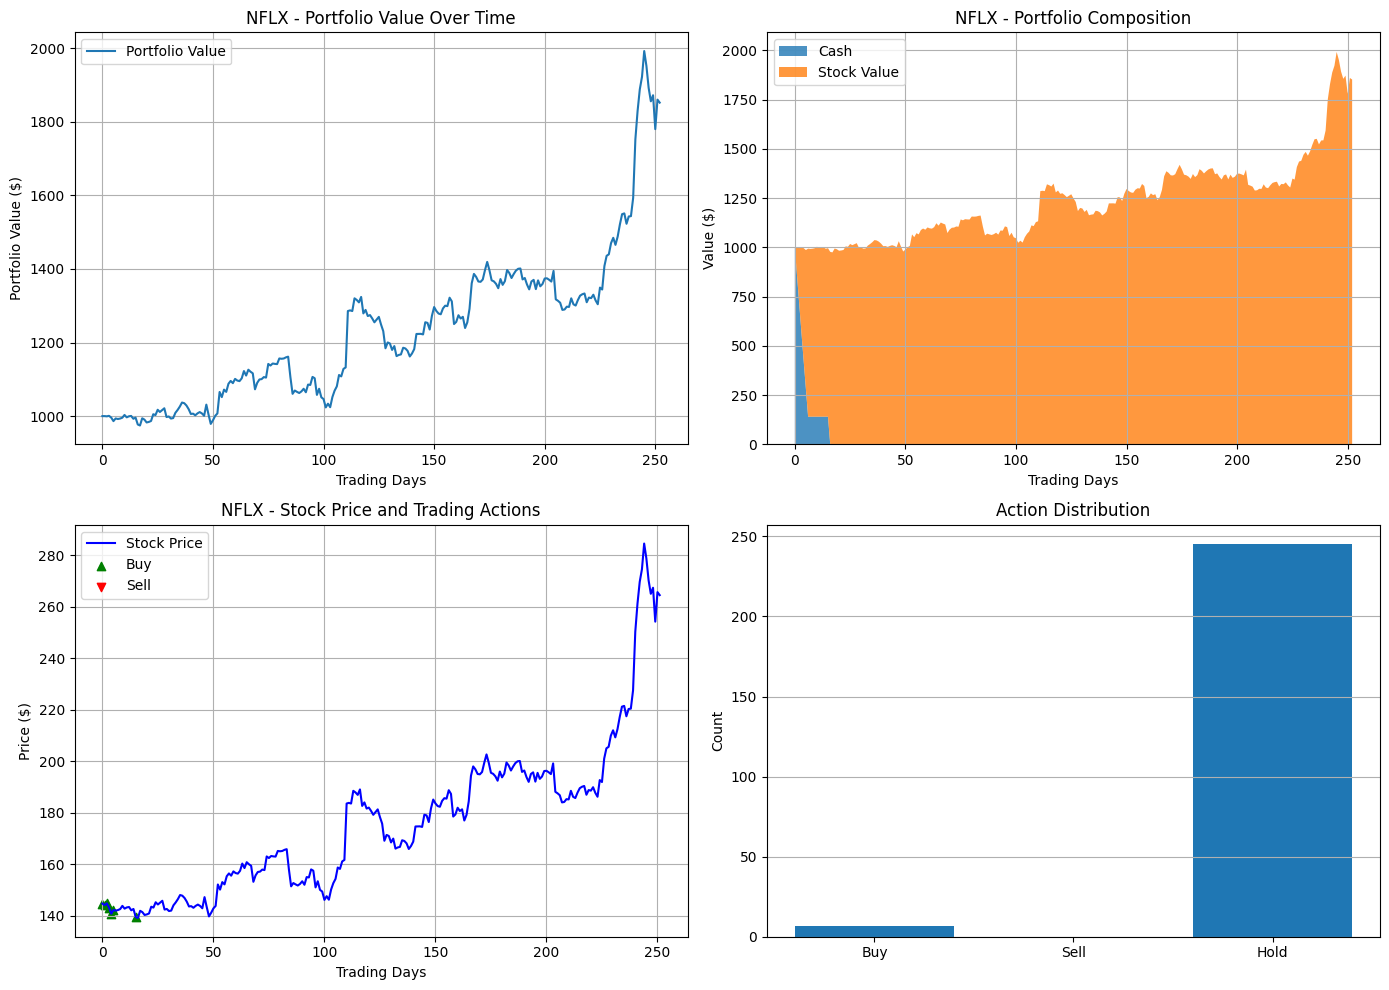


Testing model on ADBE...


<ipython-input-49-6cc925855d2d>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['5day_MA'][:4] = 0
<ipython-input-49-6cc925855d2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Testing model on ADBE stock...
Test period: 2017-02-08 to 2018-02-07
Number of trading days: 252

===== Performance Summary =====
Initial portfolio value: $1000.00
Final portfolio value: $1596.74
Total return: 59.67%
Buy & Hold return: 65.62%
Strategy outperformance: -5.95%
Maximum drawdown: 9.27%
Number of buys: 8
Number of sells: 0
Number of holds: 244


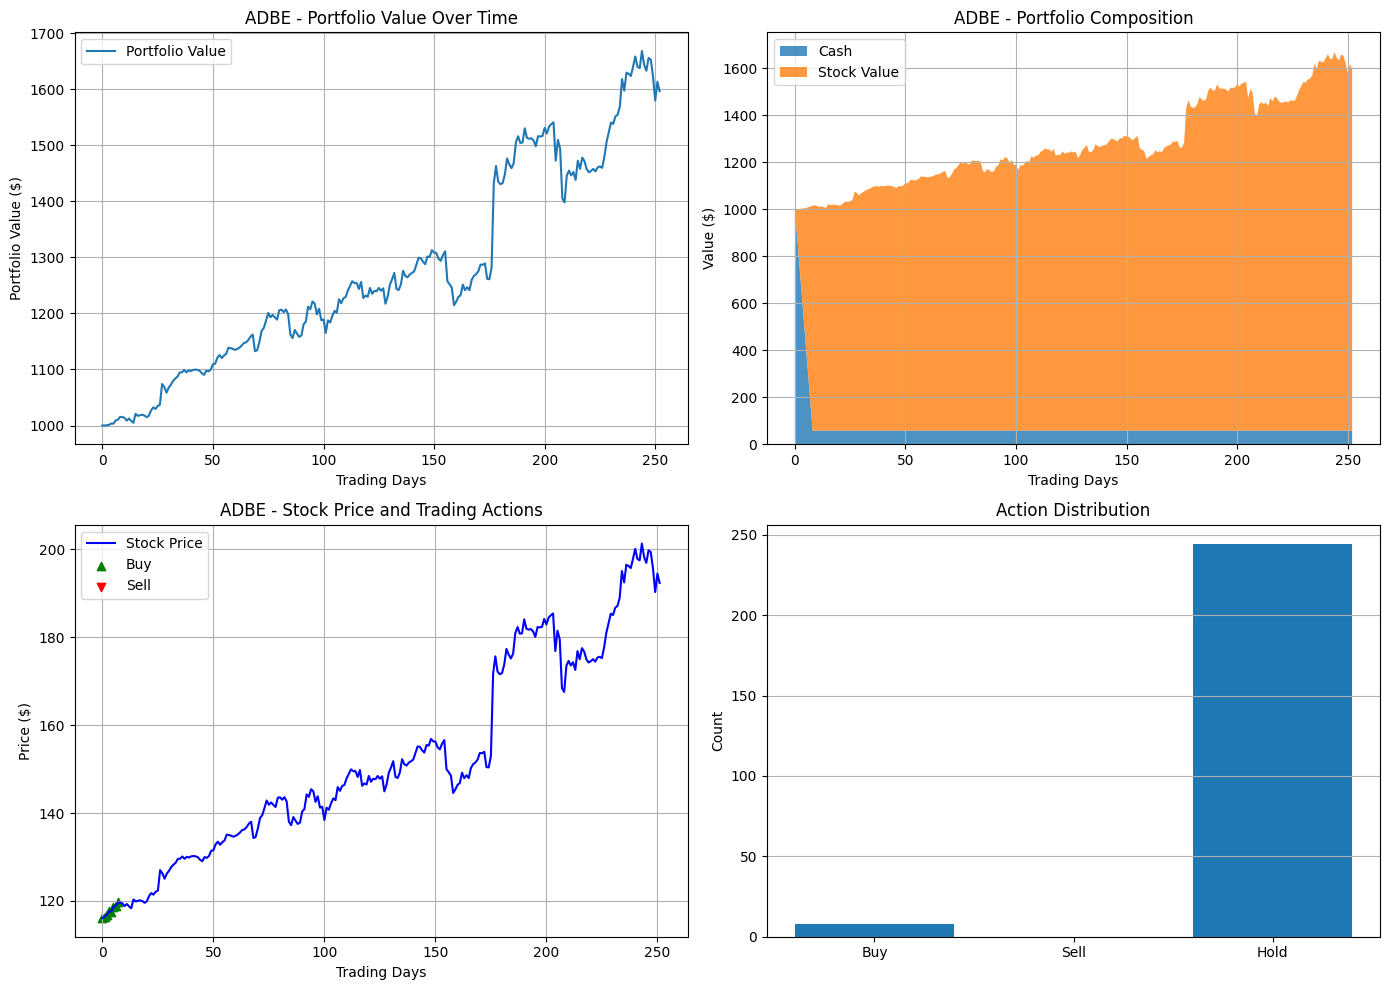


===== Cross-Stock Performance Summary =====
Number of stocks tested: 7
Average return: 45.07%
Average outperformance vs buy & hold: -4.21%
Percentage of stocks outperformed: 14.3%


<ipython-input-57-256b6ffdbe61>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stock_symbol', y='outperformance', data=outperf_df,


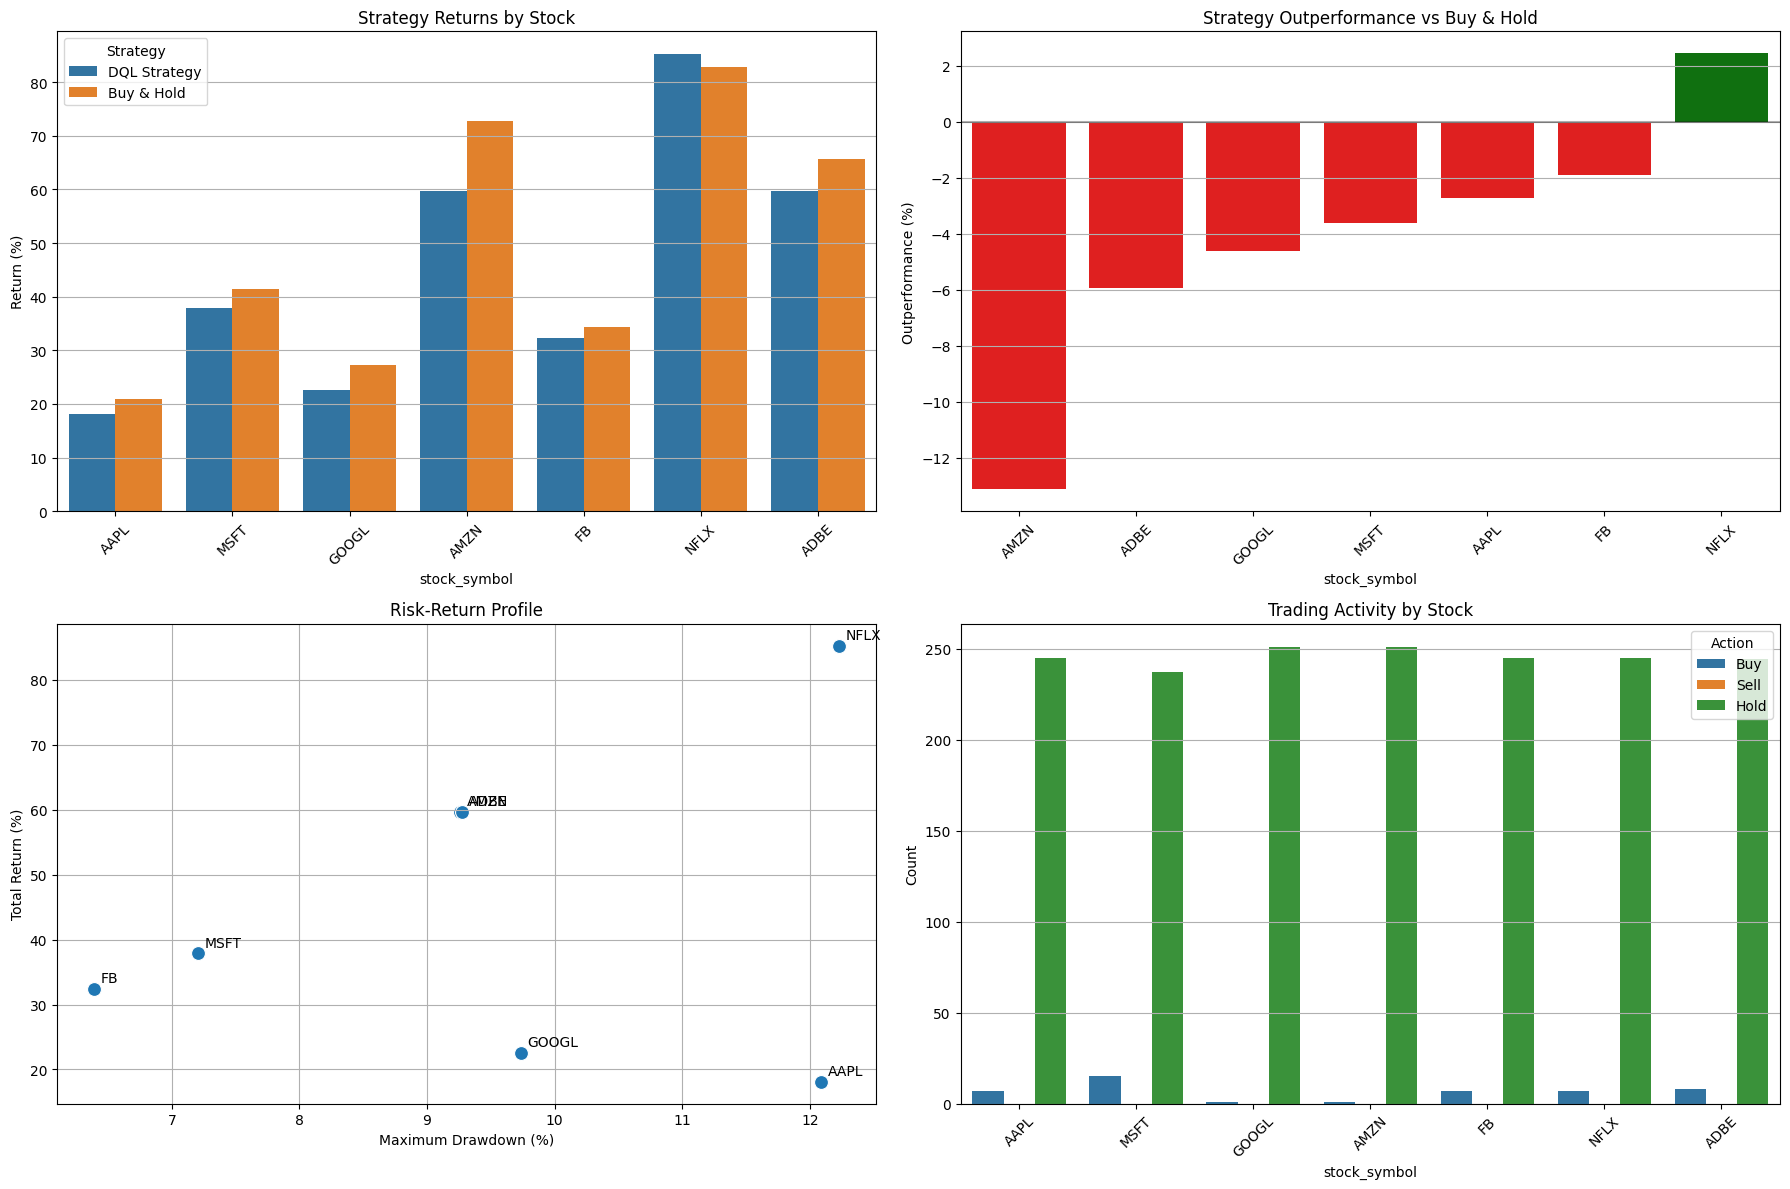

In [ ]:
test_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'FB', 'NFLX', 'ADBE']
cross_stock_results = analyze_multiple_stocks(test_stocks, loaded_model)

**Comparative Analysis Table**

In [ ]:
def create_comparative_table(results_df, benchmark_results=None):

    import pandas as pd
    import numpy as np

    # Calculate average DQL performance
    dql_avg = {
        'Strategy': 'DQL (Average)',
        'Total Return (%)': results_df['total_return_pct'].mean(),
        'Max Drawdown (%)': results_df['max_drawdown_pct'].mean(),
        'Sharpe Ratio': results_df.get('sharpe_ratio', pd.Series()).mean(),
        'Win Rate (%)': results_df.get('win_rate', pd.Series()).mean(),
        'Volatility (%)': results_df.get('volatility_annualized', pd.Series()).mean()
    }

    # Add top performing stock
    best_idx = results_df['total_return_pct'].idxmax()
    best_stock = results_df.loc[best_idx]

    dql_best = {
        'Strategy': f'DQL (Best - {best_stock["stock_symbol"]})',
        'Total Return (%)': best_stock['total_return_pct'],
        'Max Drawdown (%)': best_stock['max_drawdown_pct'],
        'Sharpe Ratio': best_stock.get('sharpe_ratio', np.nan),
        'Win Rate (%)': best_stock.get('win_rate', np.nan),
        'Volatility (%)': best_stock.get('volatility_annualized', np.nan)
    }

    comparison_rows = [dql_avg, dql_best]

    # Add buy & hold average results
    bh_avg = {
        'Strategy': 'Buy & Hold (Average)',
        'Total Return (%)': results_df['buy_hold_return_pct'].mean(),
        'Max Drawdown (%)': np.nan,  # Not calculated for buy & hold in the test function
        'Sharpe Ratio': np.nan,
        'Win Rate (%)': np.nan,
        'Volatility (%)': np.nan
    }
    comparison_rows.append(bh_avg)

    if benchmark_results:
        for name, bench_df in benchmark_results.items():
            bench_avg = {
                'Strategy': f'{name} (Average)',
                'Total Return (%)': bench_df['total_return_pct'].mean(),
                'Max Drawdown (%)': bench_df.get('max_drawdown_pct', pd.Series()).mean(),
                'Sharpe Ratio': bench_df.get('sharpe_ratio', pd.Series()).mean(),
                'Win Rate (%)': bench_df.get('win_rate', pd.Series()).mean(),
                'Volatility (%)': bench_df.get('volatility_annualized', pd.Series()).mean()
            }
            comparison_rows.append(bench_avg)

    comparison_df = pd.DataFrame(comparison_rows)

    # Format the table
    comparison_df['Total Return (%)'] = comparison_df['Total Return (%)'].map('{:.2f}'.format)
    comparison_df['Max Drawdown (%)'] = comparison_df['Max Drawdown (%)'].map(lambda x: '{:.2f}'.format(x) if not pd.isna(x) else 'N/A')
    comparison_df['Sharpe Ratio'] = comparison_df['Sharpe Ratio'].map(lambda x: '{:.2f}'.format(x) if not pd.isna(x) else 'N/A')
    comparison_df['Win Rate (%)'] = comparison_df['Win Rate (%)'].map(lambda x: '{:.2f}'.format(x) if not pd.isna(x) else 'N/A')
    comparison_df['Volatility (%)'] = comparison_df['Volatility (%)'].map(lambda x: '{:.2f}'.format(x) if not pd.isna(x) else 'N/A')

    print("\n===== Strategy Comparison Table =====")
    print(comparison_df.to_string(index=False))

    # For the research paper, you might want to save this as a LaTeX table
    latex_table = comparison_df.to_latex(index=False, float_format="%.2f")
    with open('strategy_comparison.tex', 'w') as f:
        f.write(latex_table)

    return comparison_df


In [ ]:
comparison_table = create_comparative_table(cross_stock_results)


===== Strategy Comparison Table =====
            Strategy Total Return (%) Max Drawdown (%) Sharpe Ratio Win Rate (%) Volatility (%)
       DQL (Average)            45.07             9.45          N/A          N/A            N/A
   DQL (Best - NFLX)            85.24            12.23          N/A          N/A            N/A
Buy & Hold (Average)            49.28              N/A          N/A          N/A            N/A
